<a href="https://colab.research.google.com/github/robertomoragad/Estadistica/blob/master/Modelo_simulacion_estocastica_discreta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IE03.3 Modelo de simulación estocástica discreta

En el presente notebook vamos a compartir un modelo de simulación discreta que he desarrollado para representar la operación de un centro de ayuda, al cual le llamaremos **Help Desk**.

El modelo es muy sencillo y puede ser ajustado para adaptarse perfectamente a otras realidades de procesos, servicios y negocios, como:

* centro de atención de clientes
* unidad de venta y activación de productos/servicios
* equipos de desarrollo y explotación de software
* atención médica / urgencias 
* línea de ensamble
* otros.

Una vez creado el modelo con la ayuda de python y el framework **SimPy**, procederemos a correr simulaciones de un escenario actual, con el propósito de conocer el rendimiento inicial del sistema Help Desk.  Luego procederemos a desarrollar distintos experimentos con el objetivo de buscar un escenario que satisfaga las necesidades de negocio que serán planteadas. Para tal efecto aplicaremos análisis estadístico que nos permita determinar la mejor solución.

**¿Qué es una simulación?**

Es una representación de un sistema del mundo real. Podemos usar modelos matemáticos o computacionales para estudiar cómo funciona un sistema, o qué sucede cuando se cambian partes de el.
Las simulaciones se utilizan en centros de antención, bancos, restaurantes, aeropuertos, mecánicos, hospitales y muchos otros sistemas donde la mala asignación de recursos y aqruitecturas de procesos y métodos, puede provocar congestión, insatisfacción del cliente y retrasos críticos con impacto en las personas y resultados de negocio.

##Procedemos a instalar SimPy y cargar las librerías

**¿Qué es SimPy?**: 
Es un framework de simulación de eventos discretos basado en procesos, que está basado en Python estándar. SimPy se lanza como software de código abierto bajo la licencia MIT. La primera versión fue lanzada en diciembre de 2002.

In [160]:
pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [161]:
# Cargamos librerías 
import random
import simpy
import numpy as np
import scipy.stats as stats
from time import time
from tqdm.notebook import trange # Barra de estado
import matplotlib.pyplot as plt

## <font color='blue'>Modelamiento del Help Desk</font>

Vamos a imaginar que trabajamos en un HelpDesk que tiene la misión de atender requerimientos de clientes.

El servicio que vamos a modelar tiene la siguiente estructura secuencial de procesos:

<br>
$$\text{Creación de Requerimiento} \rightarrow \text{Proceso 1} \rightarrow \text{Proceso 2} \rightarrow \text{Fin}$$
<br><br>
<img src='https://drive.google.com/uc?export=view&id=1kdEGpORIMMtnP3Xl3bZQ-gYh7o44QAtE' width="1000" align="center" style="margin-right: 20px"> 
<br>


<p style="font-size:8pt"> 
Imagen gentileza de: Roberto Moraga</p>



###Creación de Requerimiento

Por una parte tenemos clientes, quienes son los que crean tickets para solicitar una atención, a esto le llamaremos Requerimiento.

Para considerar la variabilidad a este proceso de arribo de Requerimientos al sistema Help Desk, hemos estudiado la cantidad promedio de tickets que se crean por hora (durante el último mes) y esto nos da una media de 15.0 Tickets creados por hora (este parámetro se llama lambda en una __distribución Poisson__).

$$\lambda = 15.0 \;\text{(ticket / hora)} = 0.25 \;\text{(ticket / minuto)}$$

Con este parámetro calcularemos el tiempo promedio entre llegadas de tickets al sistema, lo que nos da una media en minutos igual a 4.0 (minutos/ticket), es decir, en promedio un ticket arriba al sistema Help Desk cada 4 minutos. Incorporaremos una __distribución exponencial__ a esta variable, tal como se aprecia en la imagen superior.

$$ 1/\lambda = 1 / 0.25  = 4.0 \;\text{(minutos/ticket)}$$

Una vez creado el ticket (Requerimiento) este es depositado en un Backlog (cola) único, al cual le llamaremos **Backlog #1**. En este lugar los tickets esperan hasta que exista disponibilidad de un Agente del __Proceso #1__ para ser atendido.




###Proceso N°1

Este proceso corresponde a la primera parte del trabajo que debe ser desarrollado para atender y resolver por completo el Requerimiento.

Este proceso es ejecutado por __Agentes de proceso #1__, ellas son personas especializadas en esta etapa del servicio. Actualmente el sistema cuenta con 2 __Agentes de Proceso #1__.

Para incorporar la variabilidad que existe en este __Proceso #1__, hemos estudiado el tiempo de ciclo de este proceso, el cual sigue una distribución Gamma, tal como se muestra en la imagen superior. Este proceso tiene una media de 17.9 minutos de duración.

Una vez finalizada esta parte del servicio, el ticket queda en un segundo backlog único, al cual le llamaremos **Backlog #2**.  En este lugar los tickets esperan hasta que exista disponibilidad de un __Agente del Proceso #2__ para ser atendido y finalizar por completo el trabajo requerido por los clientes.

###Proceso N°2

Este proceso corresponde a la segunda y última parte del trabajo que debe ser desarrollado para resolver por completo el Requerimiento.

Este proceso es ejecutado por __Agentes de proceso #2__, ellas son personas especializadas en esta etapa del servicio. Actualmente el sistema cuenta con 2 __Agentes de Proceso #2__.

Para incorporar la variabilidad que existe en este __Proceso #2__, hemos estudiado el tiempo de ciclo de este proceso, el cual sigue una distribución Gamma, tal como se muestra en la imagen superior. Este proceso tiene una media de 24.5 minutos de duración.

Una vez finalizada esta parte del servicio, el ticket queda resuelto y así se finaliza por completo el Requerimiento del cliente.



###Simulación y Respuestas

El escenario que será simulado corresponde a la situación inicial del Help Desk. Este escenario cuenta con los siguientes parámetros:

* Tasa de creación tickets: $\lambda$ = 15 (ticket/hora)
* Tiempo entre creación de tickets sigue distribución Exponencial con:
  * $1/ \lambda$ = 4 minutos
* Tiempo de proceso #1 sigue distribución Gamma con 
  * $\alpha$ = 9.0
  * $\beta$ = 2.0
* Tiempo de proceso #2 sigue distribución Gamma con 
  * $\alpha$ = 7.0
  * $\beta$ = 3.5
* Cantidad Agentes proceso N°1:   2 personas
* Cantidad Agentes proceso N°2:   2 personas

El tiempo de simulación será de 8 horas, ya que se necesita evaluar el rendimiento de un día de trabajo en el Help Desk.

> 1 día laboral = 8 horas cronológicas

Las respuestas del sistema que serán medidas son:
* Cantidad de tickets creados en un día laboral
* Cantidad de tickets resueltos en un día laboral
* Nivel de atención de un día laboral. Correponde a la proporción de los tickets que fueron resueltos del total de tickets creados.
* Leadtime end to end de un día laboral. Corresponde al tiempo promedio de duración de un ticket, desde que es creado por cliente hasta que este es resuelto.


## <font color='blue'>Pequeñas consideraciones previas</font>
El simulador opera en base a funciones generadoras, las cuales entregan un resultado (una llamada, una llegada de un cliente, una atención finalizada, etc.) en base a los tiempos generados de forma aleatoria por una distribución de probabilidad específica. Veamos un ejemplo:

In [162]:
# Se define una semilla en Numpy la cual define el punto de partida de la secuencia pseudoaleatoria
# Todos los objetos de scipy.stats operan con la semilla de Numpy
np.random.seed(22)

# En la simulación definimos funciones generadoras
def g(alpha, beta):
    """
    Devuelve un número aleatorio para una función gamma con parámetros alpha y beta
    """
    while True:
        yield stats.gamma.rvs(alpha, beta, 1)

In [163]:
alpha = 9
beta = 2
# Instanciamos el generador
a = g(alpha, 1/beta)

In [164]:
# Ejecutar varias veces
b = next(a)
b

8.898781914039947

Para generar números aleatorios, se pueden utilizar distintas librerías, e.g., `Numpy`, `random`, o `scipy.stats`. En todos los casos hay que cuidar la correcta parametrización.

In [165]:
# Generemos aleatorios para una Gamma(9,2)
# Primero con random.gammavariate

muestra_g1 = []
for i in range(1000):
    muestra_g1.append(random.gammavariate(alpha, beta))

In [166]:
# Ahora con stats.gamma 
gamma = stats.gamma(a=alpha, loc=0, scale=beta)
muestra_g2 = gamma.rvs(size=1000)

Media teórica de una Gamma(9,2)             : 18.0
Media muestra gamma con random.gammavariates: 18.24
Media muestra gamma con scipy.stats         : 17.99


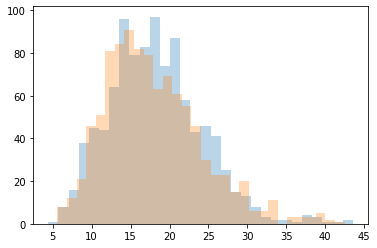

In [167]:
# Comparemos los resultados
print(f'Media teórica de una Gamma(9,2)             : {gamma.stats(moments="m")}')
print(f'Media muestra gamma con random.gammavariates: {np.mean(muestra_g1):4.2f}')
print(f'Media muestra gamma con scipy.stats         : {np.mean(muestra_g2):4.2f}')
plt.hist(muestra_g1, 30, alpha=0.3)
plt.hist(muestra_g2, 30, alpha=0.3)
plt.show()

## <font color='blue'>Creación del modelo en python con SimPy</font>

A continuación encontrarás el código que se ha desarrollado para simular el Help Desk propuesto.

In [168]:
# Inicio

# Creamos parámetros del modelo:
NUM_EMPLOYEES_1 = 2  # Número de agentes en el proceso #1 del ciclo de trabajo
NUM_EMPLOYEES_2 = 2  # Número de agentes en el proceso #2 del ciclo de trabajo

# Tiempos de los 2 procesos secuenciales con distribution Gamma
# proceso #1
alpha_1= 9.0
beta_1= 2.0
# proceso #2
alpha_2 = 7.00
beta_2= 3.50

SUPPORT_TIME_1 = alpha_1 * beta_1   # Minutos promedio para el trabajo del proceso #1
SUPPORT_TIME_2 = alpha_2 * beta_2   # Minutos promedio para el trabajo del proceso #2
AVG_CUSTOMER_HOUR = 15              # en promedio llegan X tickets por hora al backlog 
                                    # del HelpDesk (esto es el lambda de poisson)
CUSTOMER_INTERVAL = 60/AVG_CUSTOMER_HOUR # Crea un cliente cada X minutos
SIM_TIME = 60 * 8                     # tiempo de simulación en minutos

customers_handled = 0

# Un Help Desk tiene un número limitado de agentes (empleados) para atender requerimientos de clientes
# El ciclo de vida del Requerimiento consta de 2 procesos (etapas) secuenciales (proceso #1 y proceso #2)
# Los clientes crean un Requerimiento, este ingresa a un Backlog donde debe esperar a uno de los agentes del primer proceso
# Cuando un Requerimiento consigue disponibilidad de un agente del primer proceso, comienza a ser atendido requerimiento hasta que finaliza el proceso #1
# Una vez finalizada la parte del primer proceso, el requerimiento entra al backlog del segundo proceso
# Cuando un Requerimiento consigue disponibilidad de un agente del segundo proceso, comienza a ser atendido hasta que finaliza el proceso #2 y allí finaliza la atención

class HelpDesk(object):
    def __init__(self, env, num_employees_1, num_employees_2, 
                 support_time_1, support_time_2,
                 alpha_1=alpha_1, beta_1=beta_1,
                 alpha_2=alpha_2, beta_2=beta_2,
                 verbose=False):
        self.env = env
        self.staff_1 = simpy.Resource(env, num_employees_1)
        self.staff_2 = simpy.Resource(env, num_employees_2)
        self.support_time_1 = support_time_1
        self.support_time_2 = support_time_2
        self.alpha_1 = alpha_1
        self.beta_1 = beta_1
        self.alpha_2 = alpha_2
        self.beta_2 = beta_2
        self.dist_1 = stats.gamma(a=self.alpha_1, loc=0, scale=self.beta_1)
        self.dist_2 = stats.gamma(a=self.alpha_2, loc=0, scale=self.beta_2)
        self.verbose = verbose

    def support_1(self, customer):
        # El proceso #1 trabaja en la primera parte del Requerimiento
        random_time_1 = self.dist_1.rvs(1)[0]
        #random_time_1 = random.gammavariate(self.alpha, self.beta)
        if self.verbose: print(f"*  Proceso #1 finalizado para Cliente {customer} a las {self.env.now:.2f}")
        yield self.env.timeout(random_time_1)

    def support_2(self, customer):
        # El proceso #2 trabaja en la segunda parte del Requerimiento
        random_time_2 = self.dist_2.rvs(1)[0]
        #random_time_2 = random.gammavariate(self.alpha, self.beta)
        if self.verbose: print(f"** Proceso #2 finalizado para Cliente {customer} a las {self.env.now:.2f}")
        yield self.env.timeout(random_time_2)

def customer(env, name, help_desk, verbose):
    # Los clientes (cada cliente tiene un nombre) crean Requerimientos en el Help Desk y para ser resueltos por agentes
    # Luego los Requerimiento de clientes comienzan a ser atendidos por un Agente del proceso #1, esperan hasta
    # que finaliza la la primera parte del trabajo del proceso #1, luego el requerimiento ingresa al backlog del proceso #2
    # El Requerimiento comienza a ser atendido por un Agente del proceso #2, los clientes esperan hasta que finaliza la segunda parte
    # del trabajo del proceso #2, y luego el Requerimiento finaliza por completo, saliendo del Help Desk (para no volver de nuevo..)  
    
    arrival_time = env.now # guarda el minuto de creación del Requerimiento del cliente
    arrival_times.append(arrival_time) # calcula el tiempo en que ingresa ticket al backlog
    global customers_handled
    if verbose: print(f"Cliente {name} ingresa requerimiento al Backlog #1 a las {env.now:.2f}")
    with help_desk.staff_1.request() as request:
        yield request
        # Cliente se dirije a ser atendido por un primer agente
        if verbose: print(f"Cliente {name} comienza a ser atendido su requerimiento por el proceso #1 a las {env.now:.2f}")
        start_support_time_1 = env.now # guarda el minuto en que se inicia la atención del cliente 
        wait_times_1.append(env.now - arrival_time) #c alcula el tiempo de espera en la cola 1
        
        yield env.process(help_desk.support_1(name))
        # Cliente sale del primer proceso
        if verbose: print(f"Cliente {name} su requerimiento finaliza el proceso #1 a las {env.now:.2f}")      
        support_times_1.append(env.now - start_support_time_1) #calcula el tiempo de atención del proceso #1

    if verbose: print(f"Cliente {name} su requerimiento ingresa al Backlog #2 a las {env.now:.2f}!")
    with help_desk.staff_2.request() as request:
        yield request
        # Cliente se dirije a ser atendido por un segundo agente        
        start_support_time_2 = env.now # guarda el minuto en que se inicia la atención del cliente 
        if verbose: print(f"Cliente {name} comienza a ser atendido su requerimiento por el proceso #2 a las {start_support_time_2:.2f}")
        
        yield env.process(help_desk.support_2(name))
        # Cliente sale del segundo proceso y finaliza la atención
        if verbose: print(f"Cliente {name} su requerimiento finaliza el proceso #2 y se cierra ticket a las {env.now:.2f}")
        customers_handled += 1       
        support_times_2.append(env.now - start_support_time_2) # calcula el tiempo de atención del proceso #2
        total_times.append(env.now - arrival_time) # calcula el tiempo total (todo el proceso de atención)

def setup(env, num_employees_1, num_employees_2, support_time_1, support_time_2, customer_interval, verbose=False):
    """
    Crea un Help Desk, un número inicial de clientes y luego se mantendrá 
    creando clientes cada "CUSTOMER_INTERVAL" minutos
    """
    # Crea una instancia del Help Desk
    help_desk = HelpDesk(env, num_employees_1, num_employees_2, support_time_1, support_time_2, verbose=verbose)

    # Crea 5 clientes iniciales
    for i in range(1, 2):
        env.process(customer(env, i, help_desk, verbose=verbose))

    # Crea más clientes mientras la simulación está corriendo
    while True:
        yield env.timeout(stats.expon.rvs(loc=0, scale=(customer_interval), size=1)[0])
        i += 1
        env.process(customer(env, i, help_desk, verbose=verbose))

## <font color='blue'> Ejecución de una corrida</font>
En esta ejecución activaremos las salidas impresas (`verbose=True`) de a simulación.

In [169]:
# Setup e inicio de la simulación
print("Iniciando la simulación del Help Desk \n")

# Crear listas para almacenar datasets y su posterior análisis de resultados
arrival_times = []   # corresponde al tiempo en que ingresa al Backlog el requerimiento
wait_times_1 = []    # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
wait_times_2 = []    # corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
support_times_1 = [] # corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
support_times_2 = [] # corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
total_times = []     # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

RANDOM_SEED = 2 # fijar una semilla para correr 1 replica reproducible

t0 = time()
print(f"Se inicia la Simulación del Help Desk - por {SIM_TIME} minutos")
#random.seed(RANDOM_SEED)  #esto nos ayudará a reproducir los resultados
np.random.seed(seed=RANDOM_SEED) # Aplica la semilla para los objetos de scipy.stats

# Crea el entorno de simulación e inicia el proceso setup
env = simpy.Environment()
env.process(setup(env, NUM_EMPLOYEES_1, NUM_EMPLOYEES_2, SUPPORT_TIME_1, SUPPORT_TIME_2, CUSTOMER_INTERVAL, verbose=True))

# Ejecuta!
env.run(until=SIM_TIME)

print(f"\nClientes atendidos: {customers_handled}")
print(f"\nTiempo total de simulación: {(time() - t0):6.4f} segundos")

Iniciando la simulación del Help Desk 

Se inicia la Simulación del Help Desk - por 480 minutos
Cliente 1 ingresa requerimiento al Backlog #1 a las 0.00
Cliente 1 comienza a ser atendido su requerimiento por el proceso #1 a las 0.00
*  Proceso #1 finalizado para Cliente 1 a las 0.00
Cliente 2 ingresa requerimiento al Backlog #1 a las 2.29
Cliente 2 comienza a ser atendido su requerimiento por el proceso #1 a las 2.29
*  Proceso #1 finalizado para Cliente 2 a las 2.29
Cliente 3 ingresa requerimiento al Backlog #1 a las 4.47
Cliente 4 ingresa requerimiento al Backlog #1 a las 5.39
Cliente 5 ingresa requerimiento al Backlog #1 a las 9.25
Cliente 6 ingresa requerimiento al Backlog #1 a las 10.68
Cliente 7 ingresa requerimiento al Backlog #1 a las 11.92
Cliente 8 ingresa requerimiento al Backlog #1 a las 15.80
Cliente 2 su requerimiento finaliza el proceso #1 a las 17.19
Cliente 2 su requerimiento ingresa al Backlog #2 a las 17.19!
Cliente 2 comienza a ser atendido su requerimiento por el p

In [170]:
# Respuestas
NA = customers_handled / len(arrival_times) # Nivel de atención
print(f"Cantidad de tickets creados:   {len(arrival_times)}") # cantidad tickets creados
print(f"Cantidad de tickets resueltos: {customers_handled}") # cantidad tickets resueltos
print(f"Nivel de atención:             {NA:5.3f}") # Nivel atención
print(f"Leadtime:                      {np.mean(total_times):4.2f}") # leadtime 

Cantidad de tickets creados:   127
Cantidad de tickets resueltos: 34
Nivel de atención:             0.268
Leadtime:                      199.78


##Análisis de resultados

Luego de correr un día laboral, es decir, una réplica del modelo durante 8 horas, los resultados que vemos son:

* Cantidad de tickets creados en un día laboral = **127**
* Cantidad de tickets resueltos en un día laboral = **34** 
* Nivel de atención de un día laboral = **26.8%**
* Leadtime end to end de un día laboral = **199.78** minutos

Los datos anteriores son valores agregados del día laboral simulado, por tanto esconden el detalle. Por ejemplo si quisiéramos conocer la distribución completa de los tiempos totales de atención (que en promedio nos da un leadtime de 199.78 min) tenemos que tomar la lista creada donde está el registro de cada ticket resuelto con su tiempo total de atención.

En el siguiente gráfico podremos apreciar todo este detalle con los **34** tiempos totales de atención:

Leadtime (promedio de tiempo total): 199.784 minutos
Desv. std tiempo total: 104.751 minutos
n:  34


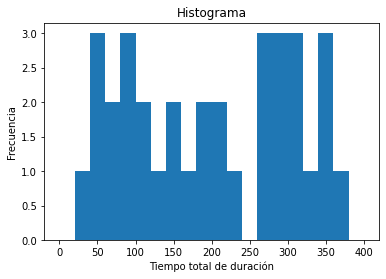

Tiempo total mínimo: 38.608 minutos
Tiempo total máximo: 360.935 minutos


In [171]:
# Graficar histograma de tiempos totales de atención

print(f'Leadtime (promedio de tiempo total): {np.mean(total_times):5.3f} minutos')
print(f'Desv. std tiempo total: {np.std(total_times):5.3f} minutos')
print('n: ', np.size(total_times))

plt.hist(total_times, bins=20, range=(0, 400))
plt.ylabel('Frecuencia')
plt.xlabel('Tiempo total de duración')
plt.title('Histograma')
plt.show()

print(f'Tiempo total mínimo: {np.min(total_times):5.3f} minutos')
print(f'Tiempo total máximo: {np.max(total_times):5.3f} minutos')

Como podemos ver, nuestro modelo, al considerar la aleatoriedad de los factores incorporados en el modelo, nos permite simular situaciones más realistas, las cuales tienen una infinidad de factores que condicionan su no-linealidad. Por esta razón podemos ver tickets con tiempos totales muy bajos cercanos a 38 minutos, y otros extremos por la derecha cercanos a los 360 minutos. Por esta razón los modelos lineales basados en valores promedios y constantes, entregan resultados que normalmente subestiman la realidad y en consecuencia no predicen correctamente las respuestas del sistema modelado.

En el siguiente gráfico hemos creado un run chart para ver cómo evolucionan los tiempos totales de los tickets. Claramente podemos ver la tendencia al alza, lo que es muy preocupante, ya que nos indica que si la jornada tuviera más de 8 horas (recordar que la simulación es de 8 horas), los tiempos seguirían subiendo, y con ello el Leadtime (promedio de tiempos totales). Claramente este sistema de trabajo se encuentra desbalanceado.



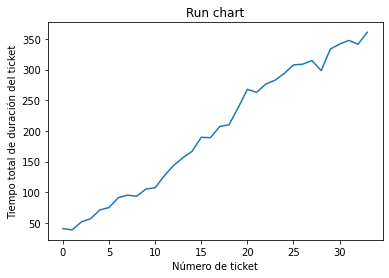

In [172]:
# Graficar run chart
plt.plot(total_times)
plt.ylabel('Tiempo total de duración del ticket')
plt.xlabel('Número de ticket')
plt.title('Run chart')
plt.show()

Recordemos que la simulación corrida anteriormente fue solo una, y como estamos en la presencia de un modelo probabilístico, tener solo una réplica para análisis y toma de decisiones, es muy riesgoso. La solución sugerida aquí es correr varias simulaciones, un buen número es 30 o más (regla de pulgar), y con sus respuestas construir histogramas y calcular intervalos, que nos entreguen mayor confiabilidad de los resultados obtenidos.

A continuación presentaremos el análisis de resultados luego de correr 300 veces el modelo de situación inicial. Recordemos que el modelo inicial cuenta con 2 agentes en __Proceso #1__ y otros 2 agentes en el __Proceso #2__, por tanto en total tiene 4 agentes nuestro Help Desk.


## <font color='blue'>Simulación de $n$ corrdidas</font>
Realizaremos una simulación de $n=300$ corridas. Esta vez desactivaremos el `verbose` para acelerar el proceso.

In [173]:
# Setup e inicio de la simulación con n corridas
print("Iniciando la simulación del Help Desk \n")

# Definimos listas vacias para almacenar las listas de resultados de cada corrida
tch = []  # Customes Handled
tat = []  # Arrival times
tNA = []  # Número de Atenciones
tLT = []  # Leadtime
tST = []  # Support time
tTT = []  # Tiempo total

# Número de corridas
corridas = 300

t0 = time()
tc = t0
print(f"Se realizan {corridas} corridas de {SIM_TIME} minutos cada una")

np.random.seed(seed=RANDOM_SEED) # Aplica la semilla para los objetos de scipy.stats

for c in trange(corridas):
    # Cada corrida individual, inicializa sus estructuras de captura de datos
    customers_handled = 0
    arrival_times = []   # corresponde al tiempo en que ingresa al Backlog el requerimiento
    wait_times_1 = []    # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
    wait_times_2 = []    # corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
    support_times_1 = [] # corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    support_times_2 = [] # corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    total_times = []     # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

    print(f"\nSIMULACION {c}")
    # Crea el entorno de simulación e inicia el proceso setup
    env = simpy.Environment()
    env.process(setup(env, NUM_EMPLOYEES_1, NUM_EMPLOYEES_2, SUPPORT_TIME_1, SUPPORT_TIME_2, CUSTOMER_INTERVAL, verbose=False))

    # Ejecuta!
    env.run(until=SIM_TIME)

    print(f"\nClientes atendidos:            {customers_handled}")

    # Respuestas
    NA = customers_handled / len(arrival_times) # Nivel de atención
    print(f"Cantidad de tickets creados:   {len(arrival_times)}") # cantidad tickets creados
    print(f"Cantidad de tickets resueltos: {customers_handled}") # cantidad tickets resueltos
    print(f"Nivel de atención:             {NA:6.4f}") # Nivel atención
    print(f"Leadtime:                      {np.mean(total_times):4.2f}") # leadtime 
    tch.append(customers_handled)
    tat.append(arrival_times)
    tNA.append(NA)
    tLT.append(np.mean(total_times))
    tTT.append(total_times)
    print(f"\nTiempo total de simulación {c}: {(time() - tc):4.2f} segundos")
    tc = time()
print(f"\nTiempo total de simulación: {(time() - t0):4.2f} segundos")

Iniciando la simulación del Help Desk 

Se realizan 300 corridas de 480 minutos cada una


  0%|          | 0/300 [00:00<?, ?it/s]


SIMULACION 0

Clientes atendidos:            34
Cantidad de tickets creados:   127
Cantidad de tickets resueltos: 34
Nivel de atención:             0.2677
Leadtime:                      199.78

Tiempo total de simulación 0: 0.08 segundos

SIMULACION 1

Clientes atendidos:            34
Cantidad de tickets creados:   119
Cantidad de tickets resueltos: 34
Nivel de atención:             0.2857
Leadtime:                      210.69

Tiempo total de simulación 1: 0.04 segundos

SIMULACION 2

Clientes atendidos:            41
Cantidad de tickets creados:   129
Cantidad de tickets resueltos: 41
Nivel de atención:             0.3178
Leadtime:                      193.61

Tiempo total de simulación 2: 0.05 segundos

SIMULACION 3

Clientes atendidos:            36
Cantidad de tickets creados:   118
Cantidad de tickets resueltos: 36
Nivel de atención:             0.3051
Leadtime:                      199.19

Tiempo total de simulación 3: 0.05 segundos

SIMULACION 4

Clientes atendidos:          

### Análisis de Resultados Modelo situación inicial con 4 agentes (2 + 2)

* Cantidad agentes en proceso N° 1 = **2**
* Cantidad agentes en proceso N° 2 = **2**

####Cantidad de tickets creados en un día laboral

Media               : 121.017
Mediana             : 120.000
Desviación estándar : 10.756
Con un 0.9 de Nivel de confianza el intervalo está entre: 103.32 y 138.71
Con un 0.9 de Nivel de confianza el intervalo está entre: 103.00 y 139.00


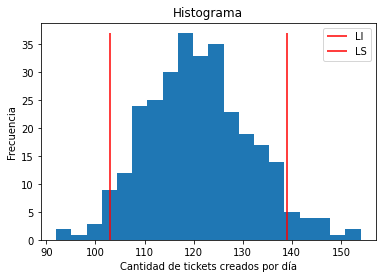

In [174]:
# Lista tat "cantidad de tickets creados" luego de las 300 réplicas 

q_creados_2_2 = [len(i) for i in tat]
print(f'Media               : {np.mean(q_creados_2_2):5.3f}')
print(f'Mediana             : {np.median(q_creados_2_2):5.3f}')
print(f'Desviación estándar : {np.std(q_creados_2_2):5.3f}')

# cálculo intervalos
# aplicando distribución Normal
alpha = 0.10
NC = 1 - alpha # nivel de confianza
Z = stats.norm.ppf(1-(alpha)/2)
LI = np.mean(q_creados_2_2) - ( Z * np.std(q_creados_2_2))
LS = np.mean(q_creados_2_2) + ( Z * np.std(q_creados_2_2))
print(f"Con un {NC} de Nivel de confianza el intervalo está entre: {LI:6.2f} y {LS:6.2f}")
# aplicando Poisson (dado que es una variable discreta)
LI_p = stats.poisson(np.mean(q_creados_2_2)).ppf(alpha/2)
LS_p = stats.poisson(np.mean(q_creados_2_2)).ppf(1-alpha/2)
print(f"Con un {NC} de Nivel de confianza el intervalo está entre: {LI_p:6.2f} y {LS_p:6.2f}")

# graficando
f, b, i = plt.hist(q_creados_2_2, bins=20)
plt.vlines(ymin=0, ymax=max(f), x=LI_p,  colors='r', label='LI')
plt.vlines(ymin=0, ymax=max(f), x=LS_p,  colors='r', label='LS')
plt.ylabel('Frecuencia')
plt.xlabel('Cantidad de tickets creados por día')
plt.title('Histograma')
plt.legend()
plt.show()


El análisis arrojó que en promedio un día laboral recibirá 121 tickets, y con una seguridad del 90% podemos concluir que la cantidad de tickets creados por día estará entre 103.32 y 138.71.

Recordemos que el lambda definido al inicio del modelamiento era de 15 tickets por hora, si hubiésemos modelado el Help Desk de forma determinística siempre tendríamos 120 tickets por día (8 horas x 15 ticket/hora). La probabilidad de que ocurra esta situación es cercana a un 3.6%, lo que hubiese generado análisis y conclusiones erróneas.



In [175]:
# probabilidad de tener en un día 120 tickets
prob_120= stats.poisson(np.mean(q_creados_2_2)).pmf(120)
print(F"Probabilidad de tener en un día 120 tickets: {prob_120:6.4f}")

Probabilidad de tener en un día 120 tickets: 0.0362


####Cantidad de tickets resueltos en un día laboral

Media               : 36.753
Mediana             : 37.000
Desviación estándar : 2.383
Con un 0.9 de Nivel de confianza el intervalo está entre:  32.83 y  40.67


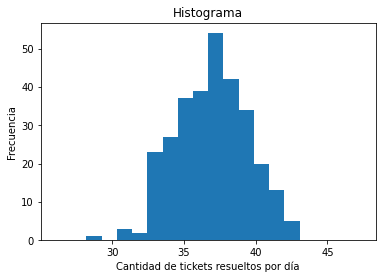

valor mínimo:  29
valor máximo:  43


In [176]:
# Lista tch "cantidad de tickets resueltos" luego de las 300 réplicas 

q_resueltos_2_2 = tch
print(f'Media               : {np.mean(q_resueltos_2_2):5.3f}')
print(f'Mediana             : {np.median(q_resueltos_2_2):5.3f}')
print(f'Desviación estándar : {np.std(q_resueltos_2_2):5.3f}')

# calculo intervalos
# aplicando Normal
alpha = 0.10
NC = 1 - alpha # nivel de confianza
Z = stats.norm.ppf(1-(alpha)/2)
LI = np.mean(q_resueltos_2_2) - ( Z * np.std(q_resueltos_2_2))
LS = np.mean(q_resueltos_2_2) + ( Z * np.std(q_resueltos_2_2))
print(f"Con un {NC} de Nivel de confianza el intervalo está entre: {LI:6.2f} y {LS:6.2f}")

plt.hist(q_resueltos_2_2, bins=20, range=(min(q_resueltos_2_2)*0.9, max(q_resueltos_2_2)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Cantidad de tickets resueltos por día')
plt.title('Histograma')
plt.show()

#calculo de min y max
print('valor mínimo: ', np.min(q_resueltos_2_2))
print('valor máximo: ', np.max(q_resueltos_2_2))

El análisis arrojó que en promedio en un día laboral se finalizarán/solucionarán 36 tickets, y con una seguridad del 90% podemos concluir que la cantidad de tickets resueltos por día estará entre 32 y 40.

####Nivel de atención de un día laboral

Media               : 0.306
Mediana             : 0.307
Desviación estándar : 0.032
Con un 0.9 de Nivel de confianza el intervalo está entre:   0.25 y   0.36


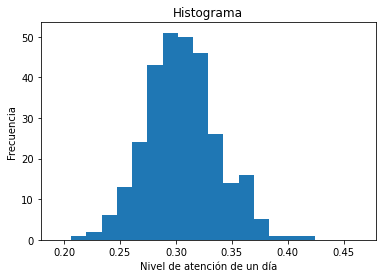

In [177]:
# Lista tNA "nivel de atención" luego de las 300 réplicas 

nivel_atencion_2_2 = tNA
print(f'Media               : {np.mean(nivel_atencion_2_2):5.3f}')
print(f'Mediana             : {np.median(nivel_atencion_2_2):5.3f}')
print(f'Desviación estándar : {np.std(nivel_atencion_2_2):5.3f}')

# Cálculo intervalos
# Aplicando Normal
alpha = 0.10
NC = 1 - alpha #nivel de confianza
Z = stats.norm.ppf(1-(alpha)/2)
LI = np.mean(nivel_atencion_2_2) - ( Z * np.std(nivel_atencion_2_2))
LS = np.mean(nivel_atencion_2_2) + ( Z * np.std(nivel_atencion_2_2))
print(f"Con un {NC} de Nivel de confianza el intervalo está entre: {LI:6.2f} y {LS:6.2f}")

plt.hist(nivel_atencion_2_2, bins=20, range=(min(nivel_atencion_2_2)*0.9, max(nivel_atencion_2_2)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Nivel de atención de un día')
plt.title('Histograma')
plt.show()

El análisis arrojó que en promedio en un día laboral se podrán resolver el 30.6% de los tickets recibidos, y con una seguridad del 90% podemos concluir que  el nivel de atención diario estará entre 25% y 36%.

####Leadtime end to end de un día laboral

Media               : 185.016
Mediana             : 184.414
Desviación estándar : 16.934
Con un 0.9 de Nivel de confianza el intervalo está entre: 157.21 y 212.82


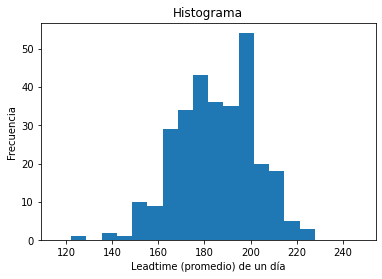

In [178]:
# Lista tlt "leadtime" luego de las 30 replicas 

leadtime_2_2 = tLT
print(f'Media               : {np.mean(leadtime_2_2):5.3f}')
print(f'Mediana             : {np.median(leadtime_2_2):5.3f}')
print(f'Desviación estándar : {np.std(leadtime_2_2, ddof=1):5.3f}')

# Cálculo intervalos
# Aplicando Normal
alpha = 0.10
NC = 1 - alpha # nivel de confianza
Z = stats.norm.ppf(1-(alpha)/2)
LI = np.mean(leadtime_2_2) - ( Z * np.std(leadtime_2_2))
LS = np.mean(leadtime_2_2) + ( Z * np.std(leadtime_2_2))
print(f"Con un {NC} de Nivel de confianza el intervalo está entre: {LI:6.2f} y {LS:6.2f}")

plt.hist(leadtime_2_2, bins=20, range=(min(leadtime_2_2)*0.9, max(leadtime_2_2)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Leadtime (promedio) de un día')
plt.title('Histograma')
plt.show()

El análisis arrojó que en promedio la media diaria de tiempos totales de atención (leadtime de un día laboral) es de 185 minutos, y con una seguridad del 90% podemos concluir que la media diaria de tiempos totales de atención (leadtime de un día laboral) estará entre 157 y 212 minutos.


Recordemos que el gráfico anterior nos muestra la distribución de las medias de un día laboral (8 horas) de los tiempos totales de atención de los tickets que si fueron resueltos, por tanto aquí tendremos cálculos de estas medias con muestras de entre 32 y 40 tickets (véase distribución de tickets resueltos). Por tanto este gráfico nos esconde el detalle de la distribución de los tiempos totales de los tickets, para ver este detalle a continuación presentaremos un histograma de estos tiempos con las 300 réplicas corridas, lo que simularán 300 días de 8 horas, que en promedio resolvieron 36.753 tickets, por esta razón la muestra de tiempos totales es de 11026 tickets.

Media              : 184.74
Desviación estándar: 89.20
n: 11026.00


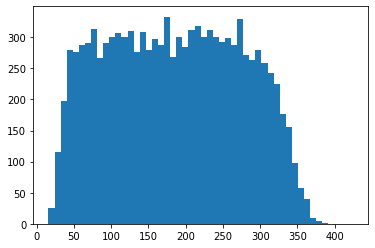

In [179]:
# ANEXO
# Lista  tiempos totales (end to end) creado a partir los casos generados en 300 réplicas

tiempos_totales = [val for sublist in tTT for val in  sublist]
print(f"Media              : {np.mean(tiempos_totales):4.2f}")
print(f"Desviación estándar: {np.std(tiempos_totales):4.2f}")
print(f"n: {np.size(tiempos_totales):4.2f}")
plt.hist(tiempos_totales, bins=50, range=(min(tiempos_totales)*0.9, max(tiempos_totales)*1.1))
plt.show()

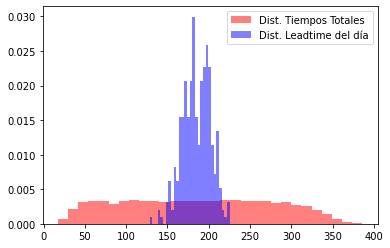

In [180]:
#Graficando en el mismo plano cartesiano la distribución de los 300 leadtime diarios y
#la distribución de los 11026 tickets

plt.hist(tiempos_totales, bins=30, density=True, color='r', alpha=0.5, label="Dist. Tiempos Totales")
plt.hist(leadtime_2_2, bins=30, density=True, color='b', alpha=0.5, label="Dist. Leadtime del día")
plt.legend()
plt.show()

Es evidente que la distribución de los tiempos totales de los tickets tiene mayor variabilidad que la de las medias diarias, además tiene una forma platicúrtica en comparación con las medias diarias (leadtime de un día laboral).

La explicación al fenómeno anterior la podemos encontrar en el Teorema del Límite Central (TLC), la que nos dice que independiente de la distribución que tenga la variable medida en los individuos objetos de estudio, si tomamos de esta población de individuos muestras grandes, y luego calculamos a estas muestras sus medias muestrales, estás medias muestrales tendrán una distribución normal.

# <font color='blue'>Desafío de negocio</font>

Vamos a imaginar que el negocio y sus clientes se encuentran insatisfechos con los resultados que ha exhibido el Help Desk durante los último meses, esto porque los indicadores monitoreados no cumplen las expectativas planteadas al inicio de este servicio.

Los indicadores más relevantes para este servicio son 2:

1. Nivel de atención de un día laboral.
2. Leadtime (end to end) de un día laboral. 

Ambos se encuentran fuera del target definido de > 85% para el primero y < 60 minutos para el segundo.

Actualmente el Help Desk tiene el siguiente rendimiento promedio diario, calculado a partir de los indicadores diarios de los últimos 30 días:

* Nivel de atención de un día laboral = 29%
* Leadtime (end to end) de un día laboral = 184 minutos ($\sigma= 16$ min)

Del Análisis de resultados del modelo inicial podemos apreciar que estos 2 indicadores (29% y 184 min), se encuentran contenidos en el intervalo de confianza de 90%. Por tanto podemos concluir que el modelo predice de buena forma el rendimiento **diario** del sistema de trabajo.

**Test de hipótesis de 1 muestra**

Otra manera para validar si el modelo predice bien o tiene buen ajuste,  sería por medio de un test de hipótesis para la media de 1 muestra, el que será ejecutado aplicando la prueba Z de 1 muestra v/s un target, esto debido a que tenemos más de 30 réplicas.

La prueba de hipótesis será planteada de la siguiente forma:

* $H_0$: La media de "leadtime diario" es igual a 184 minutos
* $H_1$: La media de "leadtime diario" es diferente a 184 minutos

En términos simples lo que vamos a evaluar aquí es revisar si es que la media de los 300 'Leadtime diarios" generados a partir de los datos de nuestras simulaciones, se situa entre 2 límites críticos, si esto ocurre la media de "leadtime diarios" caería en zona de no rechazo de $H_0$, de lo contario se rechazaría la $H_0$.

Estos límites son:

$$LI = 184 - 1.96* {\frac{16}{\sqrt{300}}} = 182.19 $$ 
$$LS = 184 + 1.96* {\frac{16}{\sqrt{300}}} = 185.81 $$ 

Veamos en el siguiente procedimiento la operación completa de un **análisis post-hoc** para evaluar nuestro Test de hipótesis, considerando un nivel de significancia (Error tipo I) de 0.05.

In [181]:
# Pasos
# 1) Cargamos data línea base (población)
Mu = 184 #minutos
Sigma = 16 #minutos

# 2) Cargar datos de la muestra
n = np.size(leadtime_2_2) #tamaño de la muestra
xbar = np.mean(leadtime_2_2) #media de la muestra
S = np.std(leadtime_2_2, ddof=1) # desv. std insesgada no es necesaria utilizarla dado que se conoce Sigma


# 3) Determinar el nivel de significancia de la prueba
alpha = 0.05

# 4) Definir hipótesis a contrastar (prueba bilateral - 2 colas)
#    H0:   Mu = 184
#    H1:   Mu ≠  184

# regla decisión (2 colas)
#    no rechazar H0 si: -Zcritico <= Z <= Z crítico
#    rechazar H0 si:  Z < -Zcritico  o  Z > Zcritico  

# 5) Determinar el valor crítico de Z
Zcritico = stats.norm.ppf(1 - (alpha/2))# 2 colas, en esta forma en Python encontramos el valor critico en el Z-test.
print(f'Z crítico: {Zcritico: 4.3f}')

# 5.1) Calcular el valor en minutos correspondiente al Z crítico
valor_minutos_zcritico_izquierda = stats.norm(Mu, Sigma/np.sqrt(n)).ppf(alpha/2) # buscar valor cola izquierda
valor_minutos_zcritico_derecha = stats.norm(Mu, Sigma/np.sqrt(n)).ppf(1-alpha/2) # buscar valor cola derecha
print(f"Valor media para Z crítico por izquierda: {valor_minutos_zcritico_izquierda: 4.3f}")
print(f"Valor media para Z crítico por derechaa: {valor_minutos_zcritico_derecha: 4.3f}")

Z crítico:  1.960
Valor media para Z crítico por izquierda:  182.189
Valor media para Z crítico por derechaa:  185.811


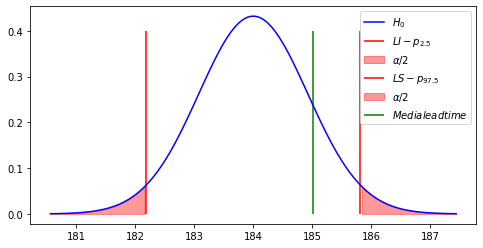

In [182]:
# visualizando la distribución de las medias muestrales cuando el n=300 
# y el límite crítico de Rechazo H0

# proyectar distribución H0
muestral_z = stats.norm(Mu, Sigma / np.sqrt(n))
x_z = np.linspace(muestral_z.ppf(0.0001), muestral_z.ppf(0.9999), 100)
pdf_z = muestral_z.pdf(x_z) # función densidad probabilidad

plt.figure(figsize=(8, 4)) # tamaño gráfico
plt.plot(x_z, pdf_z, "b", label='$H_0$') # medias H0
plt.vlines(ymin=0, ymax=0.4, x=valor_minutos_zcritico_izquierda,  colors='r', label='$LI - p_{2.5}$')
# Fill de alfa (Error tipo I)
plt.fill_between(x_z, pdf_z, 
                 where = x_z <= valor_minutos_zcritico_izquierda,
                 color='r', alpha=0.4, label=r'$\alpha/2$')

plt.vlines(ymin=0, ymax=0.4, x=valor_minutos_zcritico_derecha,  colors='r', label='$LS - p_{97.5}$')
# Fill de alfa (Error tipo I)
plt.fill_between(x_z, pdf_z, 
                 where = x_z >= valor_minutos_zcritico_derecha,
                 color='r', alpha=0.4, label=r'$\alpha/2$')
plt.vlines(ymin=0, ymax=0.4, x=xbar,  colors='g', label='$Media leadtime$')
plt.legend()
plt.show()

Para esta prueba de Hipótesis, como el valor de media muestral obtenido con las 300 replicas fue de "Media de leadtime diarios = 185.016 minutos", cifra que se situa entre los límites críticos, no se rechaza la 𝐻0 (Hipótesis nula).  Luego se puede concluir que la ""Media de leadtime diarios" obtenido por nuestro modelo de simulación no tiene una diferencia estadísticamente significativa con la media real, por tanto el modelo predice de buena forma la realidad de la operación del Help Desk..

Otra forma de evaluar este paso es calculando el valor-p (p-value), si este valor es menor al Nivel de significancia establecido, se procede a Rechazar la  𝐻0  (Hipótesis Nula), de lo contrario no se puede rechazar la  𝐻0 .

In [183]:
## 6) Calcular el estadístico Z de prueba.
Z = (xbar - Mu) / (Sigma /np.sqrt(n))
print(f'Z prueba: {Z:5.2f}')

## 7) Calcular el p-value y comparar con el nivel de significancia establecido.
# calcular p-value
pvalue = 2 * (stats.norm.sf(Z) )# Z de prueba se encuentra en cola derecha
print(f'p-value (significancia estadística): {pvalue:5.2f}') # 2 colas

# Otra forma usando Scipy
pvalue2 = 2* (stats.norm(Mu, Sigma /np.sqrt(n)).sf(xbar)) #2 colas
print(f'p-value con scipy: {pvalue2:5.2f}')

Z prueba:  1.10
p-value (significancia estadística):  0.27
p-value con scipy:  0.27


**Concluir prueba de hipótesis:**
Como el $Z$ prueba (1.10) se situa entre los $Z$ críticos, o como el valor-p ($\text{p-value}=0.27$) es mayor al Nivel de signficancia "alpha" establecido en 0.05, no se rechaza $H_0$. Por tanto se concluye que no existe una diferencia estadísticamente significativa entre la media de leadtime diarios creada a partir de 300 réplicas de 1 día de operación y la media real de leadtimes diarios.

Luego podemos concluir que nuestro modelo de simulación predice bien el comportamiento real del Help Desk.

Nota: otra forma sencilla de aplicar la prueba de hipótesis de 1 muestra, es por medio de la prueba paramétrica T Student de 1 muestra, que opera de la misma forma que la prueba Z de 1 muestra, a diferencia que T Student está diseñada principalmente para muestras pequeñas, pero entrega resultados muy similares a la prueba Z cuando las muestras son iguales o mayores a 120 unidades.

En el siguiente código apoyado de **Stats** realizaremos la prueba, si el valor-p que se obtenga es menor al nivel de significancia pre-seteado en 0.05, procedemos a rechazar la HO, de lo contrario no podremos rechazarla.

In [184]:
#Test Student de 1 muestra
res = stats.ttest_1samp(a=leadtime_2_2, popmean=184, alternative="two-sided")

#scipy.stats.ttest_1samp(a=nivel_atencion_6_7, popmean, axis=0, nan_policy='propagate', alternative='two-sided', *, keepdims=False)[source]

print(res)

Ttest_1sampResult(statistic=1.0394047314265429, pvalue=0.2994563185693606)


Una vez validado el modelo, se procede a configurar distintos escenarios donde modificaremos los parámetros de control, en este caso solo ajustaremos:

* cantidad de agentes proceso N°1
* cantidad de agentes proceso N°2

De tal forma que haremos diferentes experimentos, cada uno con 300 réplicas, ajustando dichos parámetros hasta llegar a un escenario que nos permita cumplir las metas de negocio para el Nivel de atención y el Leadtime de un día laboral.

Estos escenarios pueden ser:

* Experimento 1:
 * Cantidad agentes en proceso N° 1 = **3**
 * Cantidad agentes en proceso N° 2 = **3**
* Experimento 2:
 * Cantidad agentes en proceso N° 1 = **4**
 * Cantidad agentes en proceso N° 2 = **4**
* Experimento 3:
 * Cantidad agentes en proceso N° 1 = **5**
 * Cantidad agentes en proceso N° 2 = **5**
* Experimento 4:
 * Cantidad agentes en proceso N° 1 = **6**
 * Cantidad agentes en proceso N° 2 = **6**


Luego de realizar todos los experimentos anteriores, es el experimento número 4 el que generó los mejores resultados, es decir, la distribución de los indicadores "nivel de atención diario" y "leadtime de un día laboral" se acercan a la meta trazada por la organización.

A continuación veamos en particular los resultados de este escenario:



### Análisis de Resultados Modelo con 12 agentes (6 + 6)

* Cantidad agentes en proceso N° 1 = **6**
* Cantidad agentes en proceso N° 2 = **6**

In [185]:
# Setup e inicio de la simulación con n corridas
print("Iniciando la simulación del Help Desk \n")

# Definimos listas vacias para almacenar la lista de resultados de cada corrida
tch = []
tat = []
tNA = []
tLT = []

# Número de corridas
corridas = 300

t0 = time()
tc = t0
print(f"Se realizan {corridas} corridas de {SIM_TIME} minutos cada una")

np.random.seed(seed=RANDOM_SEED) # Aplica la semilla para los objetos de scipy.stats

for c in trange(corridas):
    # Cada corrida individual, inicializa sus estructuras de captura de datos
    customers_handled = 0
    arrival_times = []   # corresponde al tiempo en que ingresa al Backlog el requerimiento
    wait_times_1 = []    # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
    wait_times_2 = []    # corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
    support_times_1 = [] # corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    support_times_2 = [] # corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    total_times = []     # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

    print(f"\nSIMULACION {c}")
    
    NUM_EMPLOYEES_1 = 6
    NUM_EMPLOYEES_2 = 6

    # Crea el entorno de simulación e inicia el proceso setup
    env = simpy.Environment()
    env.process(setup(env, NUM_EMPLOYEES_1, NUM_EMPLOYEES_2, SUPPORT_TIME_1, SUPPORT_TIME_2, CUSTOMER_INTERVAL, verbose=False))

    # Ejecuta!
    env.run(until=SIM_TIME)

    print(f"\nClientes atendidos:            {customers_handled}")

    # Respuestas
    NA = customers_handled / len(arrival_times) # Nivel de atención
    print(f"Cantidad de tickets creados:   {len(arrival_times)}") # cantidad tickets creados
    print(f"Cantidad de tickets resueltos: {customers_handled}") # cantidad tickets resueltos
    print(f"Nivel de atención:             {NA:6.4f}") # Nivel atención
    print(f"Leadtime:                      {np.mean(total_times):4.2f}") # leadtime 
    tch.append(customers_handled)
    tat.append(arrival_times)
    tNA.append(NA)
    tLT.append(np.mean(total_times))
    print(f"\nTiempo total de simulación {c}: {(time() - tc):4.2f} segundos")
    tc = time()
print(f"\nTiempo total de simulación: {(time() - t0):4.2f} segundos")

Iniciando la simulación del Help Desk 

Se realizan 300 corridas de 480 minutos cada una


  0%|          | 0/300 [00:00<?, ?it/s]


SIMULACION 0

Clientes atendidos:            103
Cantidad de tickets creados:   132
Cantidad de tickets resueltos: 103
Nivel de atención:             0.7803
Leadtime:                      81.09

Tiempo total de simulación 0: 0.23 segundos

SIMULACION 1

Clientes atendidos:            108
Cantidad de tickets creados:   135
Cantidad de tickets resueltos: 108
Nivel de atención:             0.8000
Leadtime:                      95.03

Tiempo total de simulación 1: 0.08 segundos

SIMULACION 2

Clientes atendidos:            109
Cantidad de tickets creados:   148
Cantidad de tickets resueltos: 109
Nivel de atención:             0.7365
Leadtime:                      93.91

Tiempo total de simulación 2: 0.09 segundos

SIMULACION 3

Clientes atendidos:            98
Cantidad de tickets creados:   125
Cantidad de tickets resueltos: 98
Nivel de atención:             0.7840
Leadtime:                      64.86

Tiempo total de simulación 3: 0.12 segundos

SIMULACION 4

Clientes atendidos:        

####Cantidad de tickets creados en un día laboral

Media               : 120.957
Mediana             : 121.000
Desviación estándar : 11.788


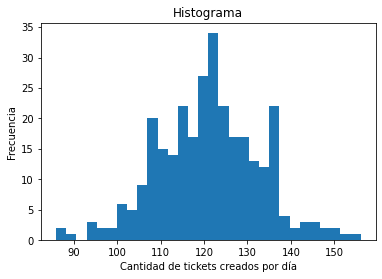

In [186]:
# Lista tat "cantidad de tickets creados" luego de las 300 réplicas 

q_creados_6_6 = [len(i) for i in tat]
print(f'Media               : {np.mean(q_creados_6_6):5.3f}')
print(f'Mediana             : {np.median(q_creados_6_6):5.3f}')
print(f'Desviación estándar : {np.std(q_creados_6_6):5.3f}')


plt.hist(q_creados_6_6, bins=30)
plt.ylabel('Frecuencia')
plt.xlabel('Cantidad de tickets creados por día')
plt.title('Histograma')
plt.show()

####Cantidad de tickets resueltos en un día laboral

Media               : 101.637
Mediana             : 102.000
Desviación estándar : 6.441


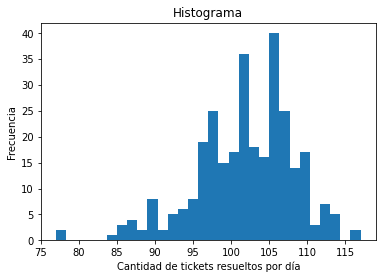

In [187]:
# Lista tch "cantidad de tickets resueltos" luego de las 300 réplicas 

q_resueltos_6_6 = tch
print(f'Media               : {np.mean(q_resueltos_6_6):5.3f}')
print(f'Mediana             : {np.median(q_resueltos_6_6):5.3f}')
print(f'Desviación estándar : {np.std(q_resueltos_6_6):5.3f}')

plt.hist(q_resueltos_6_6, bins=30)
plt.ylabel('Frecuencia')
plt.xlabel('Cantidad de tickets resueltos por día')
plt.title('Histograma')
plt.show()

####Nivel de atención de un día laboral

Media               : 0.844
Mediana             : 0.849
Desviación estándar : 0.054


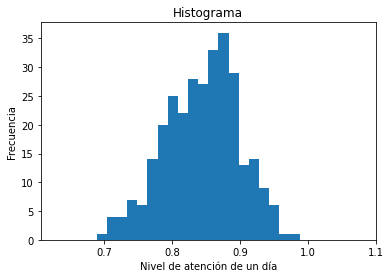

In [188]:
# Lista tNA "nivel de atención" luego de las 300 réplicas 

nivel_atencion_6_6 = tNA
print(f'Media               : {np.mean(nivel_atencion_6_6):5.3f}')
print(f'Mediana             : {np.median(nivel_atencion_6_6):5.3f}')
print(f'Desviación estándar : {np.std(nivel_atencion_6_6):5.3f}')

plt.hist(nivel_atencion_6_6, bins=30, range=(min(nivel_atencion_6_6)*0.9, max(nivel_atencion_6_6)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Nivel de atención de un día')
plt.title('Histograma')
plt.show()

####Leadtime end to end de un día laboral

Media               : 61.682
Mediana             : 58.072
Desviación estándar : 13.914


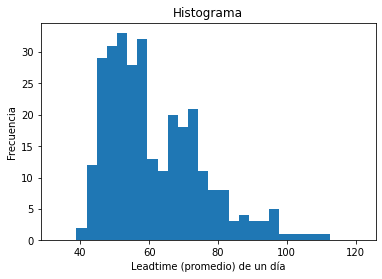

In [189]:
# Lista tLT "leadtime" luego de las 30 replicas 

leadtime_6_6 = tLT
print(f'Media               : {np.mean(leadtime_6_6):5.3f}')
print(f'Mediana             : {np.median(leadtime_6_6):5.3f}')
print(f'Desviación estándar : {np.std(leadtime_6_6):5.3f}')

plt.hist(leadtime_6_6, bins=30, range=(min(leadtime_6_6)*0.8, max(leadtime_6_6)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Leadtime (promedio) de un día')
plt.title('Histograma')
plt.show()

####Conclusión

Los resultados muestran una mejora significativa al comparar este escenario (6 + 6) V/S la situación inicial (2 + 2), esto para los 2 indicadores objeto de optimización. A modo de resumen se comparten los boxplots para ambos indicadores.



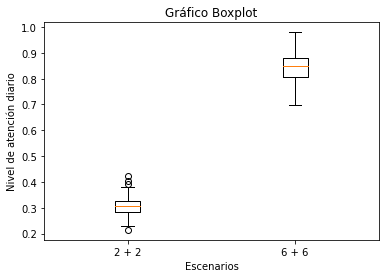

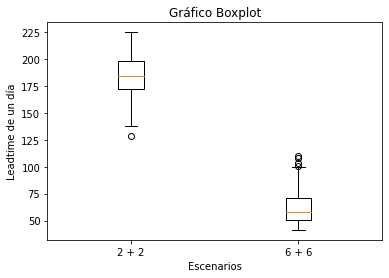

In [190]:
# Graficar boxplots de nivel de atención

columns_to_plot = [nivel_atencion_2_2, nivel_atencion_6_6]

plt.boxplot(columns_to_plot)
plt.ylabel('Nivel de atención diario')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["2 + 2", "6 + 6"])
plt.show()

columns_to_plot = [leadtime_2_2,  leadtime_6_6]

plt.boxplot(columns_to_plot)
plt.ylabel('Leadtime de un día')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["2 + 2", "6 + 6"])
plt.show()

Si bien existe una mejora significativa, aún falta mejorar para llegar a las metas planteadas. Por esta razón se continuará con nuevos experimentos, donde primero incorporaremos 1 nueva persona al Help Desk, primero en el proceso N°1 y luego otro experimento donde esta persona adicional se sumará al proceso N°2. Finalmente el último experimento será con 7 personas en el proceso N°1 y 7 personas en el proceso N°2. 

Aquí la configuración:

* Experimento 5:
 * Cantidad agentes en proceso N° 1 = **7**
 * Cantidad agentes en proceso N° 2 = **6**
* Experimento 6:
 * Cantidad agentes en proceso N° 1 = **6**
 * Cantidad agentes en proceso N° 2 = **7**
* Experimento 7:
 * Cantidad agentes en proceso N° 1 = **7**
 * Cantidad agentes en proceso N° 2 = **7**




### Análisis de Resultados Modelo con 13 agentes (7 + 6)

* Cantidad agentes en proceso N° 1 = **7**
* Cantidad agentes en proceso N° 2 = **6**

####Cantidad de tickets creados en un día laboral


In [191]:
# Setup e inicio de la simulación con n corridas
print("Iniciando la simulación del Help Desk \n")

# Definimos listas vacias para almacenar la lista de resultados de cada corrida
tch = []
tat = []
tNA = []
tLT = []

# Número de corridas
corridas = 300

t0 = time()
tc = t0
print(f"Se realizan {corridas} corridas de {SIM_TIME} minutos cada una")

np.random.seed(seed=RANDOM_SEED) # Aplica la semilla para los objetos de scipy.stats

for c in trange(corridas):
    # Cada corrida individual, inicializa sus estructuras de captura de datos
    customers_handled = 0
    arrival_times = []   # corresponde al tiempo en que ingresa al Backlog el requerimiento
    wait_times_1 = []    # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
    wait_times_2 = []    # corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
    support_times_1 = [] # corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    support_times_2 = [] # corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    total_times = []     # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

    print(f"\nSIMULACION {c}")
    
    NUM_EMPLOYEES_1 = 7
    NUM_EMPLOYEES_2 = 6

    # Crea el entorno de simulación e inicia el proceso setup
    env = simpy.Environment()
    env.process(setup(env, NUM_EMPLOYEES_1, NUM_EMPLOYEES_2, SUPPORT_TIME_1, SUPPORT_TIME_2, CUSTOMER_INTERVAL, verbose=False))

    # Ejecuta!
    env.run(until=SIM_TIME)

    print(f"\nClientes atendidos:            {customers_handled}")

    # Respuestas
    NA = customers_handled / len(arrival_times) # Nivel de atención
    print(f"Cantidad de tickets creados:   {len(arrival_times)}") # cantidad tickets creados
    print(f"Cantidad de tickets resueltos: {customers_handled}") # cantidad tickets resueltos
    print(f"Nivel de atención:             {NA:6.4f}") # Nivel atención
    print(f"Leadtime:                      {np.mean(total_times):4.2f}") # leadtime 
    tch.append(customers_handled)
    tat.append(arrival_times)
    tNA.append(NA)
    tLT.append(np.mean(total_times))
    print(f"\nTiempo total de simulación {c}: {(time() - tc):4.2f} segundos")
    tc = time()
print(f"\nTiempo total de simulación: {(time() - t0):4.2f} segundos")

Iniciando la simulación del Help Desk 

Se realizan 300 corridas de 480 minutos cada una


  0%|          | 0/300 [00:00<?, ?it/s]


SIMULACION 0

Clientes atendidos:            103
Cantidad de tickets creados:   143
Cantidad de tickets resueltos: 103
Nivel de atención:             0.7203
Leadtime:                      86.09

Tiempo total de simulación 0: 0.11 segundos

SIMULACION 1

Clientes atendidos:            86
Cantidad de tickets creados:   96
Cantidad de tickets resueltos: 86
Nivel de atención:             0.8958
Leadtime:                      44.21

Tiempo total de simulación 1: 0.05 segundos

SIMULACION 2

Clientes atendidos:            100
Cantidad de tickets creados:   127
Cantidad de tickets resueltos: 100
Nivel de atención:             0.7874
Leadtime:                      76.12

Tiempo total de simulación 2: 0.06 segundos

SIMULACION 3

Clientes atendidos:            108
Cantidad de tickets creados:   135
Cantidad de tickets resueltos: 108
Nivel de atención:             0.8000
Leadtime:                      74.39

Tiempo total de simulación 3: 0.06 segundos

SIMULACION 4

Clientes atendidos:         

Media               : 121.803
Mediana             : 121.000
Desviación estándar : 10.793


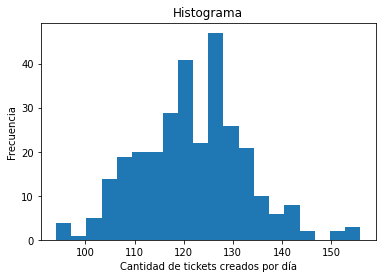

In [192]:
# Lista tat "cantidad de tickets creados" luego de las 300 réplicas 

q_creados_7_6 = [len(i) for i in tat]
print(f'Media               : {np.mean(q_creados_7_6):5.3f}')
print(f'Mediana             : {np.median(q_creados_7_6):5.3f}')
print(f'Desviación estándar : {np.std(q_creados_7_6):5.3f}')


f, b, i = plt.hist(q_creados_7_6, bins=20)
plt.ylabel('Frecuencia')
plt.xlabel('Cantidad de tickets creados por día')
plt.title('Histograma')
plt.show()

####Cantidad de tickets resueltos en un día laboral

Media               : 102.130
Mediana             : 102.000
Desviación estándar : 5.974


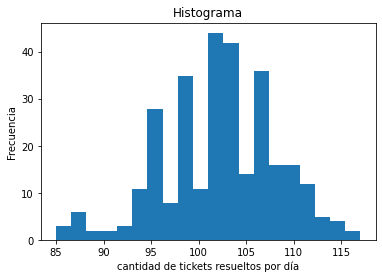

In [193]:
# Lista tch "cantidad de tickets resueltos" luego de las 300 réplicas 

q_resueltos_7_6 = tch
print(f'Media               : {np.mean(q_resueltos_7_6):5.3f}')
print(f'Mediana             : {np.median(q_resueltos_7_6):5.3f}')
print(f'Desviación estándar : {np.std(q_resueltos_7_6):5.3f}')

plt.hist(q_resueltos_7_6, bins=20)
plt.ylabel('Frecuencia')
plt.xlabel('cantidad de tickets resueltos por día')
plt.title('Histograma')
plt.show()

####Nivel de atención de un día laboral

Media               : 0.842
Mediana             : 0.848
Desviación estándar : 5.974


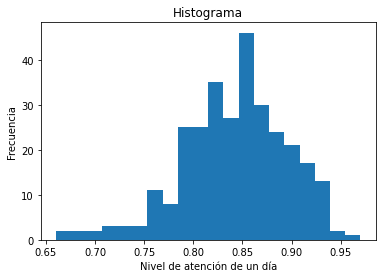

In [194]:
# Lista tNA "nivel de atención" luego de las 300 réplicas 

nivel_atencion_7_6 = tNA
print(f'Media               : {np.mean(nivel_atencion_7_6):5.3f}')
print(f'Mediana             : {np.median(nivel_atencion_7_6):5.3f}')
print(f'Desviación estándar : {np.std(q_resueltos_7_6):5.3f}')

plt.hist(nivel_atencion_7_6, bins=20)
plt.ylabel('Frecuencia')
plt.xlabel('Nivel de atención de un día')
plt.title('Histograma')
plt.show()

####Leadtime end to end de un día laboral

Media               : 60.072
Mediana             : 56.768
Desviación estándar : 12.416


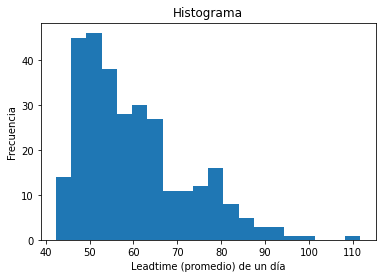

In [195]:
# Lista tlt "leadtime" luego de las 300 replicas 

leadtime_7_6 = tLT
print(f'Media               : {np.mean(leadtime_7_6):5.3f}')
print(f'Mediana             : {np.median(leadtime_7_6):5.3f}')
print(f'Desviación estándar : {np.std(leadtime_7_6):5.3f}')

plt.hist(leadtime_7_6, bins=20)
plt.ylabel('Frecuencia')
plt.xlabel('Leadtime (promedio) de un día')
plt.title('Histograma')
plt.show()

####Conclusiones 
Este escenario que adiciona una nueva persona al Help Desk (al primer proceso), no genera resultados muy diferentes al escenario con 6 y 6 agentes visto anteriormente, y en consecuencia tampoco vemos cumplimiento del target trazado por el negocio.

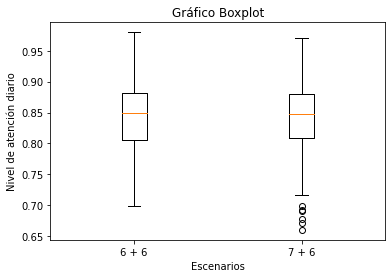

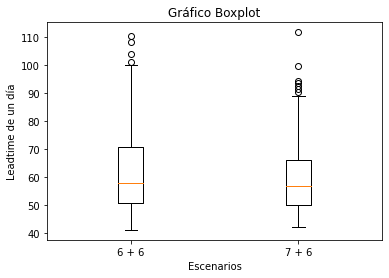

In [196]:
# Graficar boxplots de nivel de atención

columns_to_plot = [nivel_atencion_6_6, nivel_atencion_7_6]

plt.boxplot(columns_to_plot)
plt.ylabel('Nivel de atención diario')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["6 + 6", "7 + 6"])
plt.show()

columns_to_plot = [leadtime_6_6,  leadtime_7_6]

plt.boxplot(columns_to_plot)
plt.ylabel('Leadtime de un día')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["6 + 6", "7 + 6"])
plt.show()

Otra forma de verificar si los indicadores de ambos escenarios son diferentes o no, es por medio de una prueba de hipótesis, en este caso a modo de ejemplo aplicaremos una prueba de hipótesis paramétrica llamada prueba T Student de 2 muestras independientes, la aplicaremos con la ayuda de **Stats**.

La prueba de hipótesis será planteada de la siguiente forma:

* $H_0$: Las medias de "Nivel de atención diario" de ambos escenarios son iguales
* $H_1$: Las medias de "Nivel de atención diario" de ambos escenarios no son iguales

Si el valor-p que se obtenga es mayor al nivel de significancia de 0.05, no se rechazará la H0, de lo contrario si será rechazada la H0.

In [197]:
#Prueba Parametrica, T-Student 2 muestras independientes, Test de hipotesis diferencia de medias
res = stats.ttest_ind(nivel_atencion_6_6, nivel_atencion_7_6,  equal_var=False, alternative="two-sided")
print(res)


Ttest_indResult(statistic=0.52261670383237, pvalue=0.6014346394289038)


En este caso el valor-p de 0.601 es mayor al nivel de significancia de 0.05, por tanto no se rechaza la H0, luego concluimos que no existen diferencias estadísticamente significativas entre ambas medias de Nivel de atención diario.

Si quisiéramos calcular la probabilidad de cumplir el target en nivel de atención y en leadtime, podríamos hacerlo con el siguiente código:

In [198]:
#Nivel de atención
#Contador cumplimiento Umbral  

k = 0.85 #umbral nivel de atención

count = 0
for i in nivel_atencion_7_6 : 
    if i >= k : 
        count = count + 1

#calculo probabilidad de cumplir target
q_target = count
prob= (count/np.size(nivel_atencion_7_6))

print(f'Prob cumplir target Nivel de atención: {prob:5.3f}')

Prob cumplir target Nivel de atención: 0.473


In [199]:
#Leadtime
#Contador cumplimiento Umbral  

k = 60 #umbral leadtime

count = 0
for i in leadtime_7_6 : 
    if i <= k : 
        count = count + 1

#calculo probabilidad de cumplir target
q_target = count
prob= (count/np.size(leadtime_7_6))

print(f'Prob cumplir target Leadtime: {prob:5.3f}')

Prob cumplir target Leadtime: 0.580


La probabilidad es muy baja, debemos seguir iterando con otro escenario.

### Análisis de Resultados Modelo con 13 agentes (6 + 7)

* Cantidad agentes en proceso N° 1 = **6**
* Cantidad agentes en proceso N° 2 = **7**

####Cantidad de tickets creados en un día laboral

In [200]:
# Setup e inicio de la simulación con n corridas
print("Iniciando la simulación del Help Desk \n")

# Definimos listas vacias para almacenar la lista de resultados de cada corrida
tch = []
tat = []
tNA = []
tLT = []

# Número de corridas
corridas = 300

t0 = time()
tc = t0
print(f"Se realizan {corridas} corridas de {SIM_TIME} minutos cada una")

np.random.seed(seed=RANDOM_SEED) # Aplica la semilla para los objetos de scipy.stats

for c in trange(corridas):
    # Cada corrida individual, inicializa sus estructuras de captura de datos
    customers_handled = 0
    arrival_times = []   # corresponde al tiempo en que ingresa al Backlog el requerimiento
    wait_times_1 = []    # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
    wait_times_2 = []    # corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
    support_times_1 = [] # corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    support_times_2 = [] # corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    total_times = []     # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

    print(f"\nSIMULACION {c}")
    
    NUM_EMPLOYEES_1 = 6
    NUM_EMPLOYEES_2 = 7

    # Crea el entorno de simulación e inicia el proceso setup
    env = simpy.Environment()
    env.process(setup(env, NUM_EMPLOYEES_1, NUM_EMPLOYEES_2, SUPPORT_TIME_1, SUPPORT_TIME_2, CUSTOMER_INTERVAL, verbose=False))

    # Ejecuta!
    env.run(until=SIM_TIME)

    print(f"\nClientes atendidos:            {customers_handled}")

    # Respuestas
    NA = customers_handled / len(arrival_times) # Nivel de atención
    print(f"Cantidad de tickets creados:   {len(arrival_times)}") # cantidad tickets creados
    print(f"Cantidad de tickets resueltos: {customers_handled}") # cantidad tickets resueltos
    print(f"Nivel de atención:             {NA:6.4f}") # Nivel atención
    print(f"Leadtime:                      {np.mean(total_times):4.2f}") # leadtime 
    tch.append(customers_handled)
    tat.append(arrival_times)
    tNA.append(NA)
    tLT.append(np.mean(total_times))
    print(f"\nTiempo total de simulación {c}: {(time() - tc):4.2f} segundos")
    tc = time()
print(f"\nTiempo total de simulación: {(time() - t0):4.2f} segundos")

Iniciando la simulación del Help Desk 

Se realizan 300 corridas de 480 minutos cada una


  0%|          | 0/300 [00:00<?, ?it/s]


SIMULACION 0

Clientes atendidos:            115
Cantidad de tickets creados:   133
Cantidad de tickets resueltos: 115
Nivel de atención:             0.8647
Leadtime:                      48.77

Tiempo total de simulación 0: 0.11 segundos

SIMULACION 1

Clientes atendidos:            96
Cantidad de tickets creados:   106
Cantidad de tickets resueltos: 96
Nivel de atención:             0.9057
Leadtime:                      44.00

Tiempo total de simulación 1: 0.08 segundos

SIMULACION 2

Clientes atendidos:            116
Cantidad de tickets creados:   134
Cantidad de tickets resueltos: 116
Nivel de atención:             0.8657
Leadtime:                      53.00

Tiempo total de simulación 2: 0.07 segundos

SIMULACION 3

Clientes atendidos:            113
Cantidad de tickets creados:   129
Cantidad de tickets resueltos: 113
Nivel de atención:             0.8760
Leadtime:                      63.00

Tiempo total de simulación 3: 0.07 segundos

SIMULACION 4

Clientes atendidos:        

Media               : 121.347
Mediana             : 122.000
Desviación estándar : 11.341


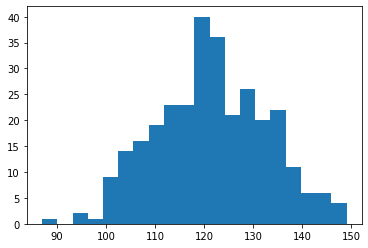

In [201]:
# Lista tat "cantidad de tickets creados" luego de las 300 réplicas 

q_creados_6_7 = [len(i) for i in tat]
print(f'Media               : {np.mean(q_creados_6_7):5.3f}')
print(f'Mediana             : {np.median(q_creados_6_7):5.3f}')
print(f'Desviación estándar : {np.std(q_creados_6_7):5.3f}')

plt.hist(q_creados_6_7, bins=20)
plt.show()

####Cantidad de tickets resueltos en un día laboral

Media               : 107.860
Mediana             : 108.000
Desviación estándar : 9.187


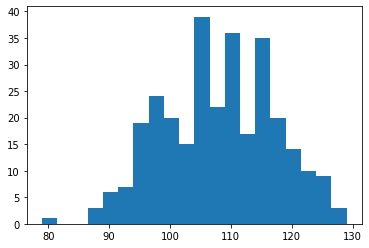

In [202]:
# Lista tch "cantidad de tickets resueltos" luego de las 300 réplicas 


q_resueltos_6_7 = tch
print(f'Media               : {np.mean(q_resueltos_6_7):5.3f}')
print(f'Mediana             : {np.median(q_resueltos_6_7):5.3f}')
print(f'Desviación estándar : {np.std(q_resueltos_6_7):5.3f}')

plt.hist(q_resueltos_6_7, bins=20)
plt.show()

####Nivel de atención de un día laboral

Media               : 0.890
Mediana             : 0.893
Desviación estándar : 0.035


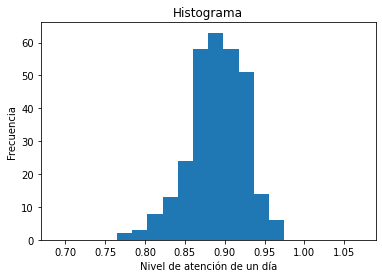

In [203]:
# Lista tNA "nivel de atención" luego de las 300 réplicas 

nivel_atencion_6_7 = tNA
print(f'Media               : {np.mean(nivel_atencion_6_7):5.3f}')
print(f'Mediana             : {np.median(nivel_atencion_6_7):5.3f}')
print(f'Desviación estándar : {np.std(nivel_atencion_6_7):5.3f}')

plt.hist(nivel_atencion_6_7, bins=20, range=(min(nivel_atencion_6_7)*0.9, max(nivel_atencion_6_7)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Nivel de atención de un día')
plt.title('Histograma')
plt.show()

####Leadtime end to end de un día laboral

Media               : 50.363
Mediana             : 48.341
Desviación estándar : 7.203


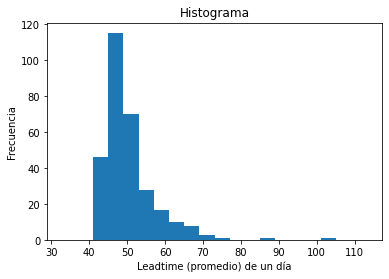

In [204]:
#dataset "leadtime" luego de las 300 replicas 

leadtime_6_7 = tLT
print(f'Media               : {np.mean(leadtime_6_7):5.3f}')
print(f'Mediana             : {np.median(leadtime_6_7):5.3f}')
print(f'Desviación estándar : {np.std(leadtime_6_7):5.3f}')

plt.hist(leadtime_6_7, bins=20, range=(min(leadtime_6_7)*0.8, max(leadtime_6_7)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Leadtime (promedio) de un día')
plt.title('Histograma')
plt.show()

####Conclusiones

Este escenario que adiciona una nueva persona al Help Desk (al segundo proceso), vemos que si genera resultados diferentes al escenario con 6 y 6 agentes visto anteriormente. Estos resultados se acercan y calzan muy bien con las metas trazadas.

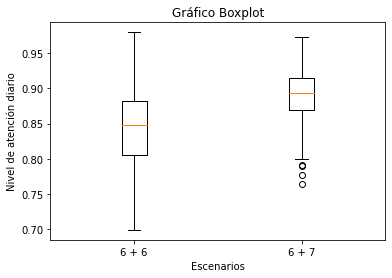

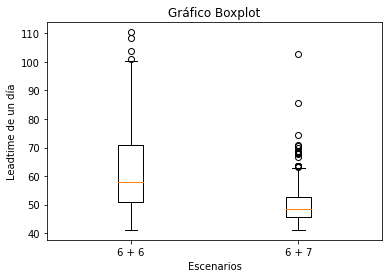

In [205]:
# Graficar boxplots de nivel de atención

columns_to_plot = [nivel_atencion_6_6, nivel_atencion_6_7]

plt.boxplot(columns_to_plot)
plt.ylabel('Nivel de atención diario')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["6 + 6", "6 + 7"])
plt.show()

columns_to_plot = [leadtime_6_6,  leadtime_6_7]

plt.boxplot(columns_to_plot)
plt.ylabel('Leadtime de un día')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["6 + 6", "6 + 7"])
plt.show()

Otra forma de verificar si los indicadores de ambos escenarios son diferentes o no, es por medio de una prueba de hipótesis, en este caso a modo de ejemplo aplicaremos una prueba de hipótesis paramétrica llamada prueba T Student de 2 muestras independientes, la aplicaremos con la ayuda de **Stats**.

La prueba de hipótesis será planteada de la siguiente forma:

* $H_0$: Las medias de "Nivel de atención diario" de ambos escenarios son iguales
* $H_1$: Las medias de "Nivel de atención diario" de ambos escenarios no son iguales

Si el valor-p que se obtenga es mayor al nivel de significancia de 0.05, no se rechazará la H0, de lo contrario si será rechazada la H0.

In [206]:
#Prueba Parametrica, T-Student 2 muestras independientes, Test de hipotesis diferencia de medias
res = stats.ttest_ind(a=nivel_atencion_6_6, b=nivel_atencion_6_7,  equal_var=False, alternative="two-sided")
print(res)

Ttest_indResult(statistic=-12.232423340606095, pvalue=2.3263944152726876e-30)


En este caso el valor-p de 0.000 es menor al nivel de significancia de 0.05, por tanto se rechaza la H0, luego concluimos que existen diferencias estadísticamente significativas entre ambas medias de Nivel de atención diario.

Dicho de otra forma, el promedio de "Nivel de atención diario" aumenta de una forma estadísticamente significativa, al pasar del escenario **6+6** personas al escenerio **6+7** personas en el Help Desk.

Esta prueba solo nos indica si las medias son diferentes o no, pero no nos indica si se cumpliría el target definido por la organización, para tal efecto debemos volver a realizar una prueba de hipótesis de 1 muestra frente al target.

**Prueba para Nivel de atención**

La prueba de hipótesis será planteada de la siguiente forma:

* $H_0$: La media de "nivel de atención diario" es menor o igual a 85%
* $H_1$: La media de "nivel de atención diario" es mayor a 85%

In [207]:
#prueba T Student de 1 muestra
res = stats.ttest_1samp(a=nivel_atencion_6_7, popmean=0.85, alternative="greater")

print(res)

Ttest_1sampResult(statistic=19.780874433114292, pvalue=1.456008614961938e-56)


En este caso el p-value es menor al nivel de significancia del 0.05, por tanto se rechaza la H0, luego el promedio de nivel de atención diario es mayor al target establecido por el negocio en **85 %**

**Prueba para Leadtime**

La prueba de hipótesis será planteada de la siguiente forma:

* $H_0$: La media de "leadtime diario" es mayor o igual a 60 minutos
* $H_1$: La media de "leadtime diario" es menor a 60 minutos

In [208]:
#prueba T Student de 1 muestra
res = stats.ttest_1samp(a=leadtime_6_7, popmean=60, alternative="less")

print(res)

Ttest_1sampResult(statistic=-23.13590618440414, pvalue=6.851186433217386e-69)


En este caso el p-value es menor al nivel de significancia del 0.05, por tanto se rechaza la H0, luego el promedio de leadtime diario es menor al target establecido por el negocio en **60** minutos.

Si quisiéramos calcular la probabilidad de cumplir el target en nivel de atención y en leadtime, podríamos hacerlo con el siguiente código:

In [209]:
#Nivel de atención
#Contador cumplimiento Umbral  

k = 0.85 #umbral nivel de atención

count = 0
for i in nivel_atencion_6_7 : 
    if i >= k : 
        count = count + 1

#calculo probabilidad de cumplir target
q_target = count
prob= (count/np.size(nivel_atencion_6_7))

print(f'Prob cumplir target Nivel de atención: {prob:5.3f}')

Prob cumplir target Nivel de atención: 0.887


In [210]:
#Leadtime
#Contador cumplimiento Umbral  

k = 60 #umbral leadtime

count = 0
for i in leadtime_6_7 : 
    if i <= k : 
        count = count + 1

#calculo probabilidad de cumplir target
q_target = count
prob= (count/np.size(leadtime_6_7))

print(f'Prob cumplir target Leadtime: {prob:5.3f}')

Prob cumplir target Leadtime: 0.900


Una buena seguridad es de 85% o 90%, en este caso ambos cuentan con una probabilidad de cumplirse cercano a 90%.


De todas formas haremos el último experimento, tomaremos este escenario óptimo (6 + 7) y le incorporaremos una nueva persona, pero ahora al primer proceso de tal forma de tener 7 y 7 agentes, veamos si se genera una mejora.

In [211]:
#NOTA: otra forma de calcular probabilidades es asumir la normalidad de las variables

#nivel de atención
target_na = 0.85
prob_mayor_85 = stats.norm(np.mean(nivel_atencion_6_7), np.std(nivel_atencion_6_7)).sf(target_na)
print(f'Prob cumplir target Nivel de atención: {prob_mayor_85:5.3f}')


#Leadtime
target_lt = 60
prob_menor_60 = stats.norm(np.mean(leadtime_6_7), np.std(leadtime_6_7)).cdf(target_lt)
print(f'Prob cumplir target Leadtime: {prob_menor_60:5.3f}')

Prob cumplir target Nivel de atención: 0.874
Prob cumplir target Leadtime: 0.910


### Análisis de Resultados Modelo con 14 agentes (7 + 7)

* Cantidad agentes en proceso N° 1 = **7**
* Cantidad agentes en proceso N° 2 = **7**

In [212]:
# Setup e inicio de la simulación con n corridas
print("Iniciando la simulación del Help Desk \n")

# Definimos listas vacias para almacenar la lista de resultados de cada corrida
tch = []
tat = []
tNA = []
tLT = []

# Número de corridas
corridas = 300

t0 = time()
tc = t0
print(f"Se realizan {corridas} corridas de {SIM_TIME} minutos cada una")

np.random.seed(seed=RANDOM_SEED) # Aplica la semilla para los objetos de scipy.stats

for c in trange(corridas):
    # Cada corrida individual, inicializa sus estructuras de captura de datos
    customers_handled = 0
    arrival_times = []   # corresponde al tiempo en que ingresa al Backlog el requerimiento
    wait_times_1 = []    # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
    wait_times_2 = []    # corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
    support_times_1 = [] # corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    support_times_2 = [] # corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    total_times = []     # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

    print(f"\nSIMULACION {c}")
    
    NUM_EMPLOYEES_1 = 7
    NUM_EMPLOYEES_2 = 7

    # Crea el entorno de simulación e inicia el proceso setup
    env = simpy.Environment()
    env.process(setup(env, NUM_EMPLOYEES_1, NUM_EMPLOYEES_2, SUPPORT_TIME_1, SUPPORT_TIME_2, CUSTOMER_INTERVAL, verbose=False))

    # Ejecuta!
    env.run(until=SIM_TIME)

    print(f"\nClientes atendidos:            {customers_handled}")

    # Respuestas
    NA = customers_handled / len(arrival_times) # Nivel de atención
    print(f"Cantidad de tickets creados:   {len(arrival_times)}") # cantidad tickets creados
    print(f"Cantidad de tickets resueltos: {customers_handled}") # cantidad tickets resueltos
    print(f"Nivel de atención:             {NA:6.4f}") # Nivel atención
    print(f"Leadtime:                      {np.mean(total_times):4.2f}") # leadtime 
    tch.append(customers_handled)
    tat.append(arrival_times)
    tNA.append(NA)
    tLT.append(np.mean(total_times))
    print(f"\nTiempo total de simulación {c}: {(time() - tc):4.2f} segundos")
    tc = time()
print(f"\nTiempo total de simulación: {(time() - t0):4.2f} segundos")

Iniciando la simulación del Help Desk 

Se realizan 300 corridas de 480 minutos cada una


  0%|          | 0/300 [00:00<?, ?it/s]


SIMULACION 0

Clientes atendidos:            116
Cantidad de tickets creados:   129
Cantidad de tickets resueltos: 116
Nivel de atención:             0.8992
Leadtime:                      45.83

Tiempo total de simulación 0: 0.12 segundos

SIMULACION 1

Clientes atendidos:            99
Cantidad de tickets creados:   111
Cantidad de tickets resueltos: 99
Nivel de atención:             0.8919
Leadtime:                      44.77

Tiempo total de simulación 1: 0.07 segundos

SIMULACION 2

Clientes atendidos:            116
Cantidad de tickets creados:   124
Cantidad de tickets resueltos: 116
Nivel de atención:             0.9355
Leadtime:                      46.87

Tiempo total de simulación 2: 0.06 segundos

SIMULACION 3

Clientes atendidos:            100
Cantidad de tickets creados:   119
Cantidad de tickets resueltos: 100
Nivel de atención:             0.8403
Leadtime:                      42.58

Tiempo total de simulación 3: 0.06 segundos

SIMULACION 4

Clientes atendidos:        

####Cantidad de tickets creados en un día laboral

Media               : 121.590
Mediana             : 122.000
Desviación estándar : 10.780


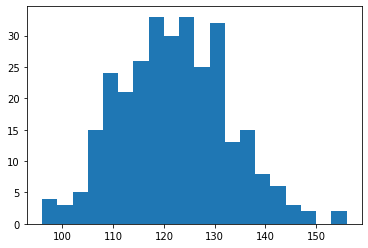

In [213]:
# Lista tat "cantidad de tickets creados" luego de las 300 réplicas 

q_creados_7_7 = [len(i) for i in tat]
print(f'Media               : {np.mean(q_creados_7_7):5.3f}')
print(f'Mediana             : {np.median(q_creados_7_7):5.3f}')
print(f'Desviación estándar : {np.std(q_creados_7_7):5.3f}')


plt.hist(q_creados_7_7, bins=20)
plt.show()

####Cantidad de tickets resueltos en un día laboral

Media               : 108.357
Mediana             : 108.000
Desviación estándar : 8.895


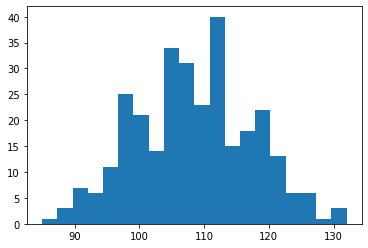

In [214]:
q_resueltos_7_7 = tch
print(f'Media               : {np.mean(q_resueltos_7_7):5.3f}')
print(f'Mediana             : {np.median(q_resueltos_7_7):5.3f}')
print(f'Desviación estándar : {np.std(q_resueltos_7_7):5.3f}')

plt.hist(q_resueltos_7_7, bins=20)
plt.show()

####Nivel de atención de un día laboral

Media               : 0.892
Mediana             : 0.894
Desviación estándar : 0.033


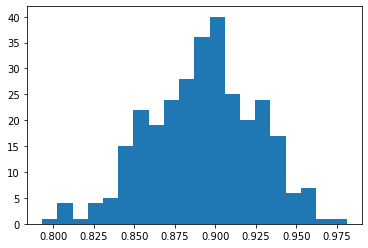

In [215]:
# Lista tNA "nivel de atención" luego de las 300 réplicas 

nivel_atencion_7_7 = tNA
print(f'Media               : {np.mean(nivel_atencion_7_7):5.3f}')
print(f'Mediana             : {np.median(nivel_atencion_7_7):5.3f}')
print(f'Desviación estándar : {np.std(nivel_atencion_7_7):5.3f}')

plt.hist(nivel_atencion_7_7, bins=20)
plt.show()

####Leadtime end to end de un día laboral

Media               : 49.267
Mediana             : 47.706
Desviación estándar : 6.429


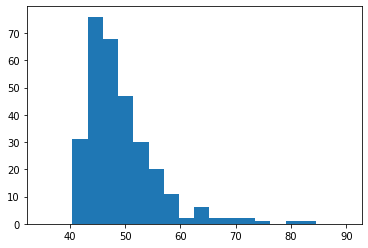

In [216]:
# Lista tLT "leadtime" luego de las 30 replicas 

leadtime_7_7 = tLT
print(f'Media               : {np.mean(leadtime_7_7):5.3f}')
print(f'Mediana             : {np.median(leadtime_7_7):5.3f}')
print(f'Desviación estándar : {np.std(leadtime_7_7):5.3f}')

plt.hist(leadtime_7_7, bins=20, range=(35, 90))
plt.show()

####Conclusiones

Al comparar los resultados de este escenario (7+7) V/S el escenario óptimo anterior con 6 + 7 agentes, no vemos diferencias. Por un tema de eficiencia recomendamos el escenario con 6 + 7 agentes.

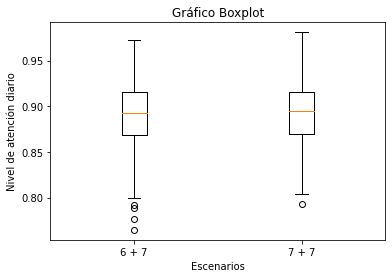

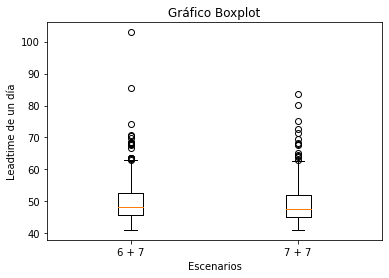

In [217]:
# Graficar boxplots de nivel de atención

columns_to_plot = [nivel_atencion_6_7, nivel_atencion_7_7]

plt.boxplot(columns_to_plot)
plt.ylabel('Nivel de atención diario')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["6 + 7", "7 + 7"])
plt.show()

columns_to_plot = [leadtime_6_7,  leadtime_7_7]

plt.boxplot(columns_to_plot)
plt.ylabel('Leadtime de un día')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["6 + 7", "7 + 7"])
plt.show()

Realicemos una prueba de hipótesis de diferencia de medias para comprobarlo.

La prueba de hipótesis será planteada de la siguiente forma:

* $H_0$: Las medias de "Nivel de atención diario" de ambos escenarios son iguales
* $H_1$: Las medias de "Nivel de atención diario" de ambos escenarios no son iguales

Si el valor-p que se obtenga es mayor al nivel de significancia de 0.05, no se rechazará la H0, de lo contrario si será rechazada la H0.


In [218]:
#Prueba Parametrica, T-Student 2 muestras independientes, Test de hipotesis diferencia de medias
res = stats.ttest_ind(a=nivel_atencion_6_7, b=nivel_atencion_7_7,  equal_var=False, alternative="two-sided")
print(res)

Ttest_indResult(statistic=-0.7297727201143339, pvalue=0.46581601028678365)


En este caso el valor-p obtenido es de 0.46, cifra superior al nivel de significancia de 0.05, por tanto no se puede rechazar la H0. Luego no existe una diferencia estadísticamente significativa entre las medias de Nivel de atención diario de ambos escenarios.

Por eficiencia, se recomienda implementar el escenario **6+7** personas en el Help Desk.

Al calcular la probabilidad de cumplir target vemos que este escenario tiene menos capacidad que el anterior con 6 + 7 agentes.

A continuación un resumen con todos los escenarios desarrollados:

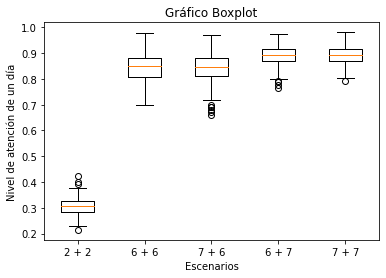

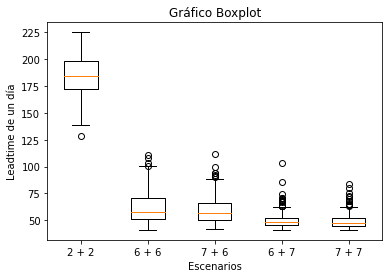

In [219]:
# Boxplot resumen

#Nivel de atención
columns_to_plot = [nivel_atencion_2_2, nivel_atencion_6_6, nivel_atencion_7_6, nivel_atencion_6_7, nivel_atencion_7_7]
plt.boxplot(columns_to_plot)
plt.ylabel('Nivel de atención de un día')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2, 3 , 4, 5],
           ["2 + 2", "6 + 6", "7 + 6", "6 + 7", "7 + 7"])
plt.show()


#Leadtime
columns_to_plot = [leadtime_2_2, leadtime_6_6, leadtime_7_6, leadtime_6_7, leadtime_7_7]
plt.boxplot(columns_to_plot)
plt.ylabel('Leadtime de un día')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2, 3 , 4, 5],
           ["2 + 2", "6 + 6", "7 + 6", "6 + 7", "7 + 7"])
plt.show()




La invitación es a seguir planteando hipótesis y a crear experimentos, por ejemplo:

* ¿qué pasa sí trabajamos con un modelo con 5 + 7 agentes?
* ¿qué pasa si al modelo con 6 + 6 agentes al proceso N°2 le aplicamos una mejora que reduzca la media de ese proceso en 2 minutos ?

o esta que procederé a testear:
* ¿qué pasa sí el proceso ahora es más Lean?, lo que significa que los agentes tendrán la habilidad de desarrollar de forma autónoma tanto el proceso N°1 como el N°2, es decir, sin tener especialista por proceso, y así evitar dependencias.


Para esta última idea procederé a crear un nuevo modelo donde los agentes trabajan de punta a punta (end to end) los requerimientos, mantendré la misma variabilidad en el arribo de requerimientos y en los tiempos de proceso N°1 y proceso N°2, pero comenzaré con 10 agentes en el Help Desk.

###Análisis de Resultados Modelo Lean con 10 agentes

* Cantidad agentes en sistema: 10 (multi-skill)

A continuación configuraremos el modo Lean del help desk :

In [244]:
#Inicio

# Creamos parámetros del modelo:
NUM_EMPLOYEES_1 = 10  # Número de agentes en el servicio Help Desk (multi-skill)


# Tiempos de los 2 procesos secuenciales con distribution Gamma
# proceso #1
alpha_1= 9.0
beta_1= 2.0
# proceso #2
alpha_2 = 7.00
beta_2= 3.50

SUPPORT_TIME_1 = alpha_1 * beta_1   # Minutos promedio para el trabajo del proceso #1
SUPPORT_TIME_2 = alpha_2 * beta_2   # Minutos promedio para el trabajo del proceso #2
AVG_CUSTOMER_HOUR = 15              # en promedio llegan X tickets por hora al backlog 
                                    # del HelpDesk (esto es el lambda de poisson)
CUSTOMER_INTERVAL = 60/AVG_CUSTOMER_HOUR # Crea un cliente cada X minutos
SIM_TIME = 60 * 8                     # tiempo de simulación en minutos

customers_handled = 0

# Un Help Desk tiene un número limitado de agentes (empleados) para atender requerimientos de clientes
# El ciclo de vida del Requerimiento consta de 2 procesos (etapas) secuenciales (proceso #1 y proceso #2)
# Los clientes crean un Requerimiento, este ingresa a un Backlog donde debe esperar a uno de los agentes del primer proceso
# Cuando un Requerimiento consigue disponibilidad de un agente del primer proceso, comienza a ser atendido requerimiento hasta que finaliza el proceso #1
# Una vez finalizada la parte del primer proceso, el requerimiento entra al backlog del segundo proceso
# Cuando un Requerimiento consigue disponibilidad de un agente del segundo proceso, comienza a ser atendido hasta que finaliza el proceso #2 y allí finaliza la atención

class HelpDesk(object):
    def __init__(self, env, num_employees_1, 
                 support_time_1,
                 alpha_1=alpha_1, beta_1=beta_1,
                 alpha_2=alpha_2, beta_2=beta_2,
                 verbose=False):
        self.env = env
        self.staff_1 = simpy.Resource(env, num_employees_1)
        self.support_time_1 = support_time_1
        self.alpha_1 = alpha_1
        self.beta_1 = beta_1
        self.alpha_2 = alpha_2
        self.beta_2 = beta_2
        self.dist_1 = stats.gamma(a=self.alpha_1, loc=0, scale=self.beta_1)
        self.dist_2 = stats.gamma(a=self.alpha_2, loc=0, scale=self.beta_2)
        self.verbose = verbose

    def support_1(self, customer):
        # El proceso #1 trabaja en la primera parte del Requerimiento
        random_time_1 = self.dist_1.rvs(1)[0] + self.dist_2.rvs(1)[0]
        #random_time_1 = random.gammavariate(self.alpha, self.beta)
        if self.verbose: print(f"*  Proceso #1 finalizado para Cliente {customer} a las {self.env.now:.2f}")
        yield self.env.timeout(random_time_1)


def customer(env, name, help_desk, verbose):
    # Los clientes (cada cliente tiene un nombre) crean Requerimientos en el Help Desk y para ser resueltos por agentes
    # Luego los Requerimiento de clientes comienzan a ser atendidos por un Agente del proceso #1, esperan hasta
    # que finaliza la la primera parte del trabajo del proceso #1, luego el requerimiento ingresa al backlog del proceso #2
    # El Requerimiento comienza a ser atendido por un Agente del proceso #2, los clientes esperan hasta que finaliza la segunda parte
    # del trabajo del proceso #2, y luego el Requerimiento finaliza por completo, saliendo del Help Desk (para no volver de nuevo..)  
    
    arrival_time = env.now # guarda el minuto de creación del Requerimiento del cliente
    arrival_times.append(arrival_time) # calcula el tiempo en que ingresa ticket al backlog
    global customers_handled
    if verbose: print(f"Cliente {name} ingresa requerimiento al Backlog #1 a las {env.now:.2f}")
    with help_desk.staff_1.request() as request:
        yield request
        # Cliente se dirije a ser atendido por un primer agente
        if verbose: print(f"Cliente {name} comienza a ser atendido su requerimiento por el proceso #1 a las {env.now:.2f}")
        start_support_time_1 = env.now # guarda el minuto en que se inicia la atención del cliente 
        wait_times_1.append(env.now - arrival_time) #c alcula el tiempo de espera en la cola 1
        
        yield env.process(help_desk.support_1(name))
        # Cliente sale del primer proceso
        if verbose: print(f"Cliente {name} su requerimiento finaliza el proceso #1 a las {env.now:.2f}")      
        customers_handled += 1   
        support_times_1.append(env.now - start_support_time_1) #calcula el tiempo de atención del proceso #1
        total_times.append(env.now - arrival_time) # calcula el tiempo total (todo el proceso de atención)

def setup(env, num_employees_1, support_time_1, customer_interval, verbose=False):
    """
    Crea un Help Desk, un número inicial de clientes y luego se mantendrá 
    creando clientes cada "CUSTOMER_INTERVAL" minutos
    """
    # Crea una instancia del Help Desk
    help_desk = HelpDesk(env, num_employees_1, support_time_1, verbose=verbose)

    # Crea 5 clientes iniciales
    for i in range(1, 2):
        env.process(customer(env, i, help_desk, verbose=verbose))

    # Crea más clientes mientras la simulación está corriendo
    while True:
        yield env.timeout(stats.expon.rvs(loc=0, scale=(customer_interval), size=1)[0])
        i += 1
        env.process(customer(env, i, help_desk, verbose=verbose))

En el siguiente código puedes configurar la cantidad de réplicas a ejecutar:

In [239]:
# Setup e inicio de la simulación con n corridas
print("Iniciando la simulación del Help Desk \n")

# Definimos listas vacias para almacenar la lista de resultados de cada corrida
tch = []
tat = []
tNA = []
tLT = []

# Número de corridas
corridas = 300

t0 = time()
tc = t0
print(f"Se realizan {corridas} corridas de {SIM_TIME} minutos cada una")

np.random.seed(seed=RANDOM_SEED) # Aplica la semilla para los objetos de scipy.stats

for c in trange(corridas):
    # Cada corrida individual, inicializa sus estructuras de captura de datos
    customers_handled = 0
    arrival_times = []   # corresponde al tiempo en que ingresa al Backlog el requerimiento
    wait_times_1 = []    # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
    #wait_times_2 = []    # corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
    support_times_1 = [] # corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    #support_times_2 = [] # corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    total_times = []     # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

    print(f"\nSIMULACION {c}")
    
    NUM_EMPLOYEES_1 = 10

    # Crea el entorno de simulación e inicia el proceso setup
    env = simpy.Environment()
    env.process(setup(env, NUM_EMPLOYEES_1, SUPPORT_TIME_1, CUSTOMER_INTERVAL, verbose=False))

    # Ejecuta!
    env.run(until=SIM_TIME)

    print(f"\nClientes atendidos:            {customers_handled}")

    # Respuestas
    NA = customers_handled / len(arrival_times) # Nivel de atención
    print(f"Cantidad de tickets creados:   {len(arrival_times)}") # cantidad tickets creados
    print(f"Cantidad de tickets resueltos: {customers_handled}") # cantidad tickets resueltos
    print(f"Nivel de atención:             {NA:6.4f}") # Nivel atención
    print(f"Leadtime:                      {np.mean(total_times):4.2f}") # leadtime 
    tch.append(customers_handled)
    tat.append(arrival_times)
    tNA.append(NA)
    tLT.append(np.mean(total_times))
    print(f"\nTiempo total de simulación {c}: {(time() - tc):4.2f} segundos")
    tc = time()
print(f"\nTiempo total de simulación: {(time() - t0):4.2f} segundos")

Iniciando la simulación del Help Desk 

Se realizan 300 corridas de 480 minutos cada una


  0%|          | 0/300 [00:00<?, ?it/s]


SIMULACION 0

Clientes atendidos:            96
Cantidad de tickets creados:   113
Cantidad de tickets resueltos: 96
Nivel de atención:             0.8496
Leadtime:                      48.28

Tiempo total de simulación 0: 0.16 segundos

SIMULACION 1

Clientes atendidos:            109
Cantidad de tickets creados:   122
Cantidad de tickets resueltos: 109
Nivel de atención:             0.8934
Leadtime:                      60.12

Tiempo total de simulación 1: 0.07 segundos

SIMULACION 2

Clientes atendidos:            96
Cantidad de tickets creados:   130
Cantidad de tickets resueltos: 96
Nivel de atención:             0.7385
Leadtime:                      67.61

Tiempo total de simulación 2: 0.06 segundos

SIMULACION 3

Clientes atendidos:            110
Cantidad de tickets creados:   139
Cantidad de tickets resueltos: 110
Nivel de atención:             0.7914
Leadtime:                      82.43

Tiempo total de simulación 3: 0.06 segundos

SIMULACION 4

Clientes atendidos:          

####Cantidad de tickets creados en un día laboral

Media               : 120.713
Mediana             : 120.000
Desviación estándar : 11.433


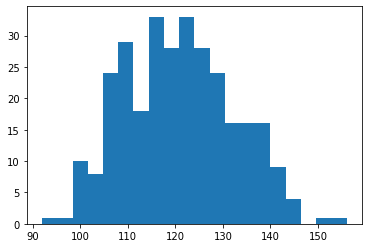

In [240]:
# Lista tat "cantidad de tickets creados" luego de las 300 réplicas 

q_creados_10 = [len(i) for i in tat]
print(f'Media               : {np.mean(q_creados_10):5.3f}')
print(f'Mediana             : {np.median(q_creados_10):5.3f}')
print(f'Desviación estándar : {np.std(q_creados_10):5.3f}')

plt.hist(q_creados_10, bins=20)
plt.show()

####Cantidad de tickets resueltos en un día laboral

Media               : 99.767
Mediana             : 101.000
Desviación estándar : 5.281


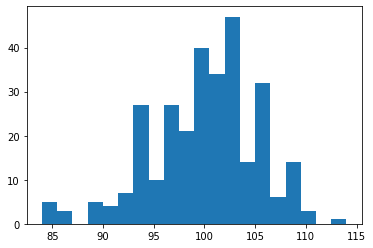

In [241]:
# Lista tch "cantidad de tickets resueltos" luego de las 300 réplicas 

q_resueltos_10 = tch
print(f'Media               : {np.mean(q_resueltos_10):5.3f}')
print(f'Mediana             : {np.median(q_resueltos_10):5.3f}')
print(f'Desviación estándar : {np.std(q_resueltos_10):5.3f}')

plt.hist(q_resueltos_10, bins=20)
plt.show()

####Nivel de atención de un día laboral

Media               : 0.831
Mediana             : 0.841
Desviación estándar : 0.059


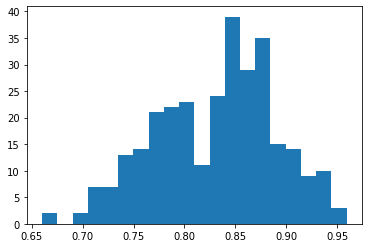

In [242]:
# Lista tNA "nivel de atención" luego de las 300 réplicas 

nivel_atencion_10 = tNA
print(f'Media               : {np.mean(nivel_atencion_10):5.3f}')
print(f'Mediana             : {np.median(nivel_atencion_10):5.3f}')
print(f'Desviación estándar : {np.std(nivel_atencion_10):5.3f}')

plt.hist(nivel_atencion_10, bins=20)
plt.show()

####Leadtime end to end de un día laboral

Media               : 61.994
Mediana             : 58.697
Desviación estándar : 14.170


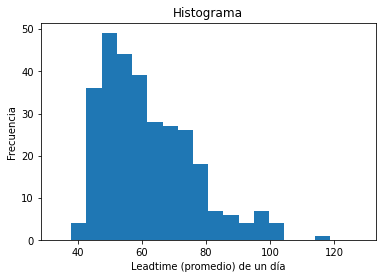

In [243]:
#dataset "leadtime" luego de las 300 replicas 

leadtime_10 = tLT
print(f'Media               : {np.mean(leadtime_10):5.3f}')
print(f'Mediana             : {np.median(leadtime_10):5.3f}')
print(f'Desviación estándar : {np.std(leadtime_10):5.3f}')

plt.hist(leadtime_10, bins=20, range=(min(leadtime_10)*0.8, max(leadtime_10)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Leadtime (promedio) de un día')
plt.title('Histograma')
plt.show()

####Conclusiones

Al analizar los resultados de este escenario, vemos que no cumple de buena forma el target planteado, pero podemos darnos cuenta que sus resultados son muy similares al escenario con procesos especializados con 6 + 6 agentes. La diferencia aquí radica en los costos asociados, ya que este escenario tendría los mismos resultados que el modelo con 12 agentes (6 + 6) pero con menores costos, aproximadamente un 17% menos.

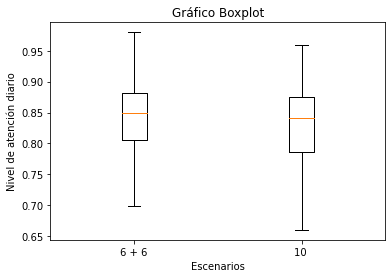

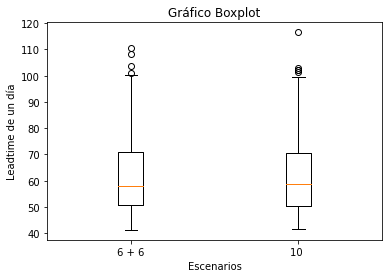

In [245]:
#Graficar boxplots de nivel de atención

columns_to_plot = [nivel_atencion_6_6, nivel_atencion_10]

plt.boxplot(columns_to_plot)
plt.ylabel('Nivel de atención diario')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["6 + 6", "10 "])
plt.show()

columns_to_plot = [leadtime_6_6,  leadtime_10]

plt.boxplot(columns_to_plot)
plt.ylabel('Leadtime de un día')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["6 + 6", "10 "])
plt.show()

Tendríamos que probar otro escenario con 11 agentes en modo lean y ver si este cumple el target. 

In [ ]:
###ponga aquí los resultados de su experimento
#

###Cierre

Para finalizar solo recordar que este es solo un ejercicio de ejemplo, hemos dejado muchos factores aleatorios fuera del modelo de simulación, así como respuestas interesantes de evaluar como por ejemplo la utilización, productividad, ingresos por ticket finalizado, premios o multas, entre otros.

Esperamos sea de gran valor y lo puedan poner en práctica ya sea ejecutando nuevos escenarios, creando más replicas, o ajustándolo a nuevos desafíos o casos de uso.

##Referencias

* Teorema del límite central  https://en.wikipedia.org/wiki/Central_limit_theorem
* Framework SimPy https://simpy.readthedocs.io/en/latest/
* Simulación discreta https://en.wikipedia.org/wiki/Discrete-event_simulation
* Sim call center: https://github.com/robertomoragad/Estadistica/blob/master/Sim_call_center_0_2.ipynb
